# House Prices - Regression Predictions YData 2024    

**Team: Random Forest Rangers** ([Dmitry Gufranov](https://www.linkedin.com/in/gufranov/), [Evgenia Amineva](https://www.linkedin.com/in/janeami/), [Valeriya Vazhnova](https://www.linkedin.com/in/gufranov/))

## Feature engineering explaration

This notebook explains why and how we deal with the features in the data set


### Import libraries

In [1]:
import pandas as pd 
import numpy as np 
import datetime

# vizualisation
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# ml
from lightgbm import LGBMRegressor
import catboost as cb
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

### Loading the data

In [3]:
# load the train data
df = pd.read_csv('train.csv')
display(df.head())
df.tail()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[5 rows x 81 columns]

### Features engineering

#### Categorical feature transformation

In this part we will explore all categorical features and choose one of the ways to deal with them:
- leave as is
- create dummy variables (fot this puprpose we will create a list cat_cols_oh)
- transform using ordinal encoder (cat_cols_oe)
- drop column (cat_cols_tdrop)


In [4]:
sns.set_palette("Accent")

# create lists to fill
cat_cols_oh, cat_cols_oe, cat_cols_tdrop = [], [], []

# create df to test functions
tdf = df.copy()

# get list of all categorical column
len(df.dtypes[df.dtypes=='object'].index)

43

In [5]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

In [6]:
def plot_cat_col(col_name, figsize=(15, 4), sp1=1, sp2=3):
    plt.figure(figsize=figsize)

    ax1 = plt.subplot(sp1, sp2, 1)
    sns.boxplot(data=df, x=col_name, y='SalePrice', ax=ax1)

    ax2 = plt.subplot(sp1, sp2, 2)
    sns.stripplot(data=df, x=col_name, y='SalePrice', hue=col_name, ax=ax2, alpha=0.5)
    ax2.set_ylabel('')

    # Create custom legend labels with the count of each category
    legend_labels = [f'{i[0]} (n={i[1]})' for i in df[col_name].value_counts().items()]
    handles, _ = ax2.get_legend_handles_labels()
    ax2.legend(handles, legend_labels, title=col_name)

    plt.show()

##### <b>MSZoning</b><br>
Identifies the general zoning classification of the sale.

A	Agriculture<br>
       C	Commercial<br>
       FV	Floating Village Residential<br>
       I	Industrial<br>
       RH	Residential High Density<br>
       RL	Residential Low Density<br>
       RP	Residential Low Density Park <br>
       RM	Residential Medium Density<br>

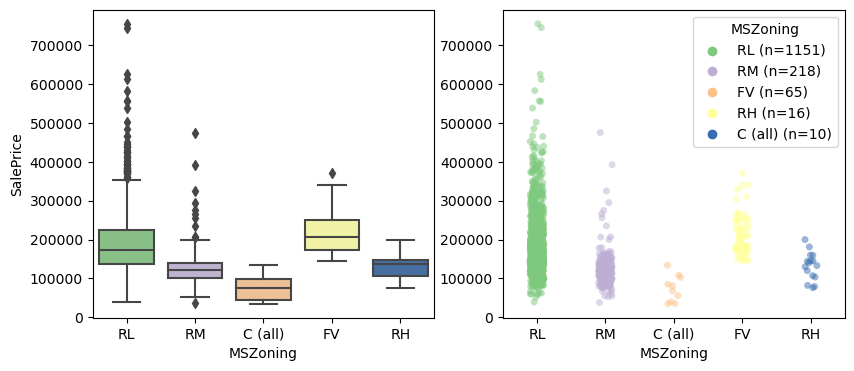

In [7]:
col_name = 'MSZoning'
plot_cat_col(col_name)

Each class in this categorical feature has different mean and variance for SalePrice, and here is not order in the values. We will create dummy features. 

In [8]:
# add the column name to a list for one hot encoding
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>Street</b><br>
Type of road access to property

Grvl	Gravel<br>
Pave	Paved

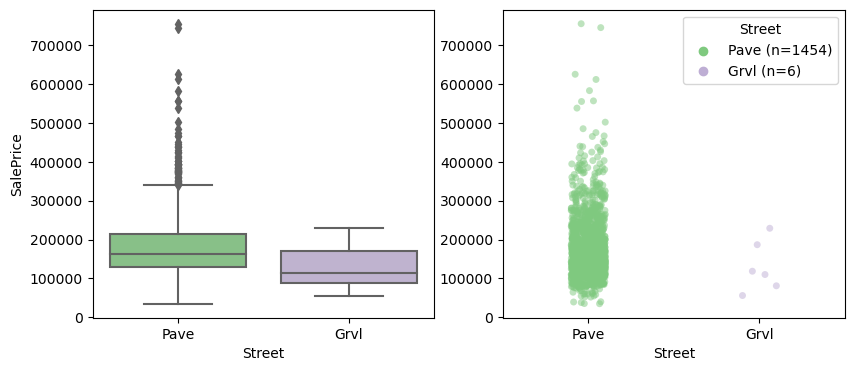

In [9]:
col_name = 'Street'
plot_cat_col(col_name)

There are very low amount of observation for the Grvl, therefore we will drop this feature

In [10]:
# create a list of columns for drop
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
cat_cols_tdrop.append(col_name)

##### <b>Alley</b><br>
Type of alley access to property

Grvl	Gravel<br>
       Pave	Paved<br>
       NA 	No alley access

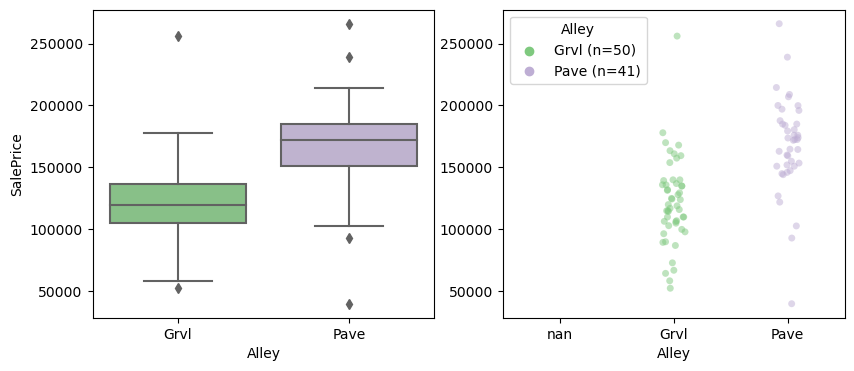

In [11]:
col_name = 'Alley'
plot_cat_col(col_name)

Each class in this categorical feature has different mean and variance for SalePrice, and here is not order in the values. We will create dummy features. 
Also Null values will be filled with the label NA

In [12]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>LotShape</b><br>
General shape of property
Reg	Regular<br>	
IR1	Slightly irregular<br>
IR2	Moderately Irregular<br>
       IR3	Irregular

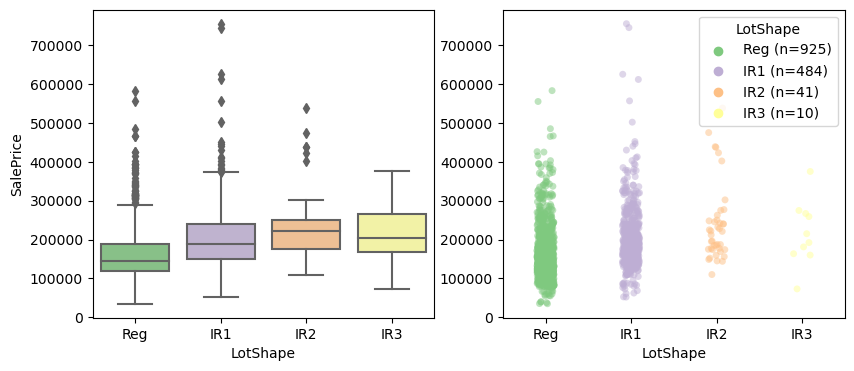

In [13]:
col_name = 'LotShape'
plot_cat_col(col_name)

Each class in this categorical feature has different mean and variance for SalePrice, and here is not order in the values. We will create dummy features. 

In [14]:
cat_cols_oh.append(col_name)

##### <b>LandContour</b><br>
Flatness of the property

Lvl	Near Flat/Level	<br>
Bnk	Banked - Quick and significant rise from street grade to building<br>
HLS	Hillside - Significant slope from side to side<br>
Low	Depression<br>

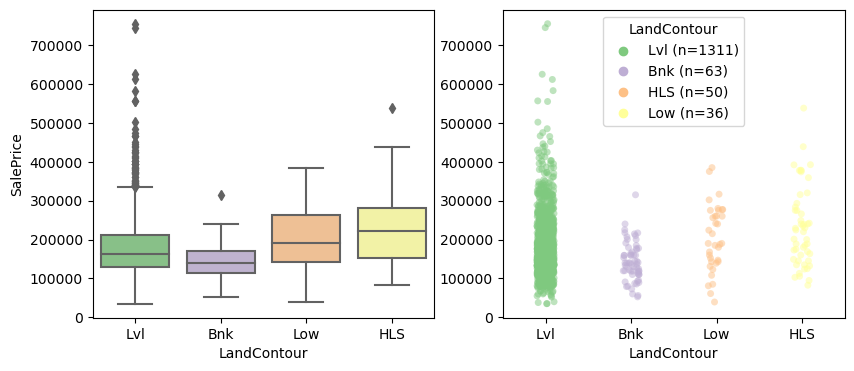

In [15]:
col_name = 'LandContour'
plot_cat_col(col_name)

Each class in this categorical feature has different mean and variance for SalePrice, and here is not order in the values. We will create dummy features. 

In [16]:
cat_cols_oh.append(col_name)

##### <b>Utilities</b><br>
Type of utilities available<br>
		
AllPub	All public Utilities (E,G,W,& S)	<br>
       NoSewr	Electricity, Gas, and Water (Septic Tank)<br>
       NoSeWa	Electricity and Gas Only<br>
       ELO	Electricity only

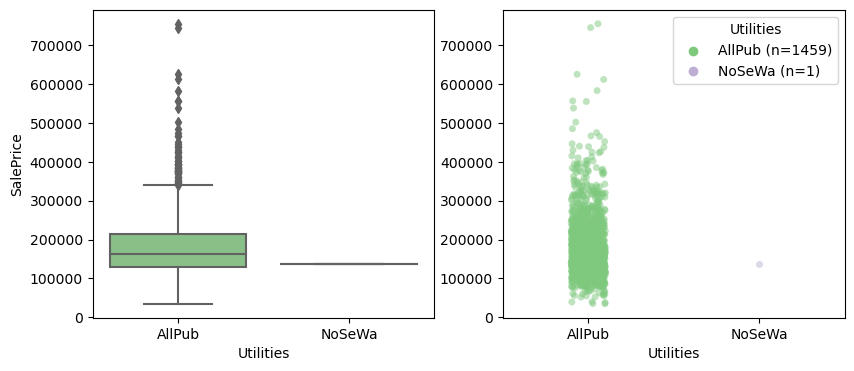

In [17]:
col_name = 'Utilities'
plot_cat_col(col_name)

The most entries are in one class, so we will drop this feature

In [18]:
cat_cols_tdrop.append('Utilities')

##### <b>LotConfig</b><br>
Lot configuration

Inside	Inside lot<br>
       Corner	Corner lot<br>
       CulDSac	Cul-de-sac<br>
       FR2	Frontage on 2 sides of property<br>
       FR3	Frontage on 3 sides of property<br>
	

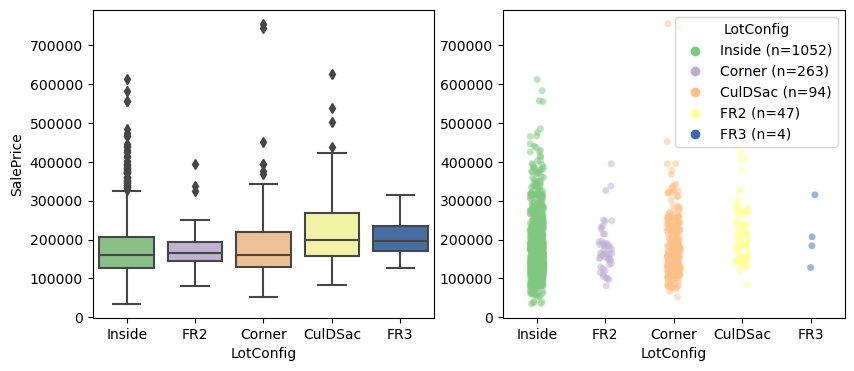

In [19]:
col_name = 'LotConfig'
plot_cat_col(col_name)

There are only 4 entries with the class FR3, and FR2 and FR3 classes look similar. We will merge these classes and create dummy features

In [20]:
# test values transformation
tdf.loc[tdf['LotConfig']=='FR3', 'LotConfig'] = 'FR2'
tdf['LotConfig'].value_counts()

LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          51
Name: count, dtype: int64

In [21]:
cat_cols_oh.append(col_name)

##### <b>LandSlope</b><br>
Slope of property
		
Gtl	Gentle slope<br>
       Mod	Moderate Slope<br>	
       Sev	Severe Slope

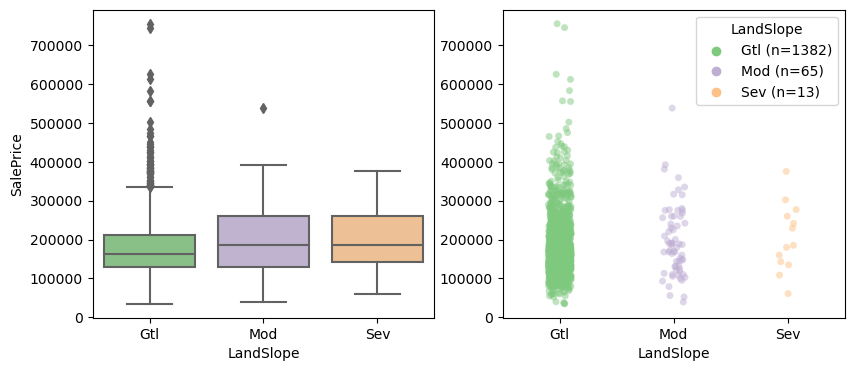

In [22]:
col_name = 'LandSlope'
plot_cat_col(col_name)

There is no big difference between Mod and Sev classes, so we will merge it and create a column which indicate gentle slope and drop the original column

In [23]:
tdf.loc[tdf['LandSlope']=='Sev', 'LandSlope'] = 'Mod'
tdf['GtlSlope'] = tdf['LandSlope'].apply(lambda x: 1 if x=='Gtl' else 0)
tdf[['LandSlope', 'GtlSlope']][:5]

LandSlope  GtlSlope
0       Gtl         1
1       Gtl         1
2       Gtl         1
3       Gtl         1
4       Gtl         1

In [24]:
cat_cols_tdrop.append(col_name)

##### <b>Neighborhood</b><br>
Physical locations within Ames city limits<br>

Blmngtn	Bloomington Heights<br>
       Blueste	Bluestem<br>
       BrDale	       Briardale<br>
       BrkSide	Brookside<br>
       ClearCr	Clear Creek<br>
       CollgCr	College Creek<br>
       Crawfor	Crawford<br>
       Edwards	Edwards<br>
       Gilbert	Gilbert<br>
       IDOTRR	       Iowa DOT and Rail Road<br>
       MeadowV	Meadow Village<br>
       Mitchel	Mitchell<br>
       Names	       North Ames<br>
       NoRidge	Northridge<br>
       NPkVill	Northpark Villa<br>
       NridgHt	Northridge Heights<br>
       NWAmes     Northwest Ames<br>
       OldTown	Old Town<br>
       SWISU	South & West of Iowa State University<br>
       Sawyer	Sawyer<br>
       SawyerW	Sawyer West<br>
       Somerst	Somerset<br>
       StoneBr	Stone Brook<br>
       Timber	Timberland<br>
       Veenker	Veenker

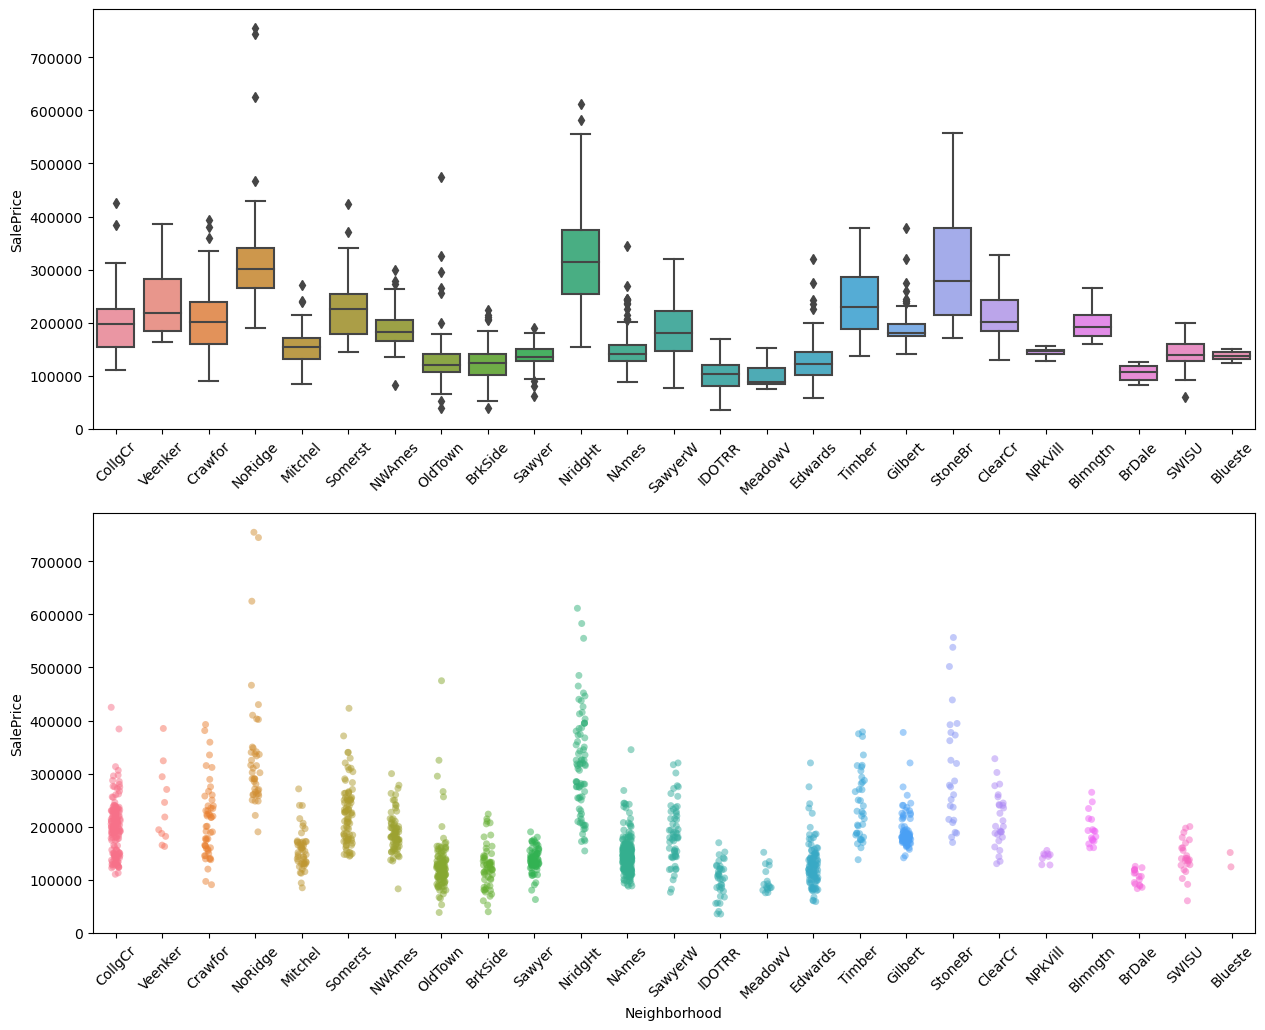

In [25]:
col_name = 'Neighborhood'

plt.figure(figsize=(15, 12))

ax1 = plt.subplot(2, 1, 1)
sns.boxplot(data=df, x=col_name, y='SalePrice', ax=ax1)
plt.xticks(rotation=45)
ax1.set_xlabel('')

ax2 = plt.subplot(2, 1, 2)
sns.stripplot(data=df, x=col_name, y='SalePrice', hue=col_name, ax=ax2, alpha=0.5)

# Create custom legend labels with the count of each category
legend_labels = [f'{i[0]} (n={i[1]})' for i in df[col_name].value_counts().items()]
handles, _ = ax2.get_legend_handles_labels()
#ax2.legend(handles, legend_labels, title=col_name)
plt.xticks(rotation=45)
ax2.get_legend().set_visible(False)
plt.show()

In [26]:
cat_cols_oh.append('Neighborhood')

##### <b>Condition1 and Condition2</b><br>
Proximity to various conditions<br>
Proximity to various conditions (if more than one is present)<br>
	
Artery	Adjacent to arterial street<br>
Feedr	Adjacent to feeder street	<br>
Norm	Normal	<br>
RRNn	Within 200' of North-South Railroad<br>
RRAn	Adjacent to North-South Railroad<br>
PosN	Near positive off-site feature--park, greenbelt, etc.<br>
PosA	Adjacent to postive off-site feature<br>
RRNe	Within 200' of East-West Railroad<br>
RRAe	Adjacent to East-West Railroad<br>

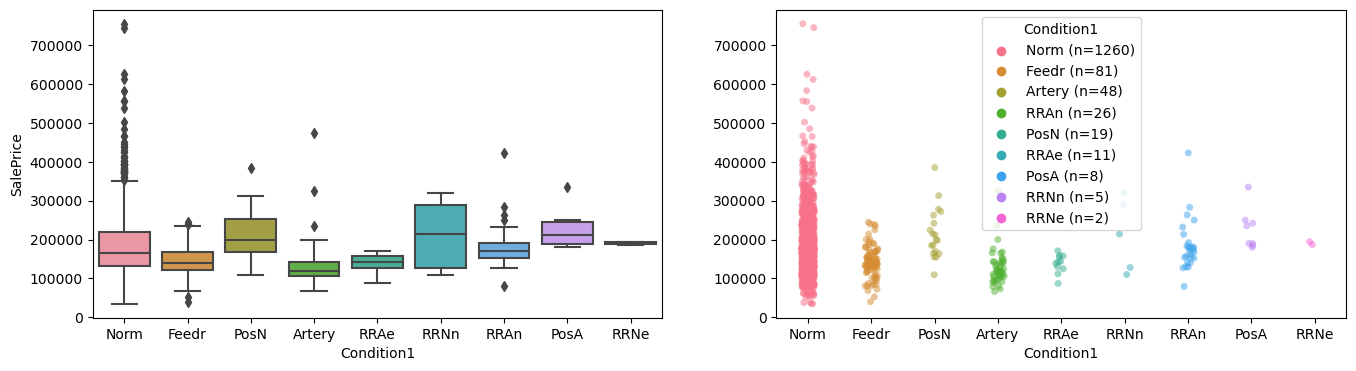

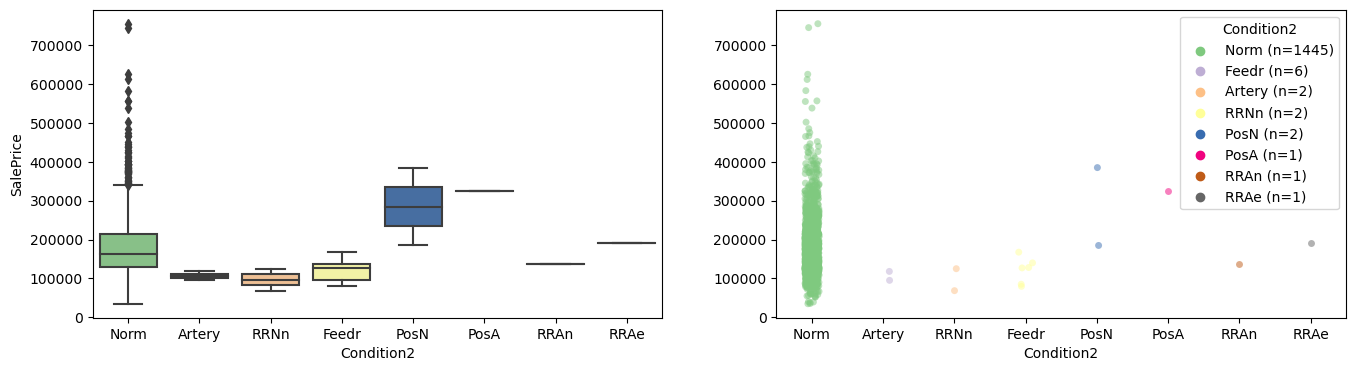

In [27]:
col_name = ['Condition1', 'Condition2']

for cn in col_name:
    plot_cat_col(cn, figsize=(25, 4))

Based on the description we will merge next classes: RRNn and RRAn, RRNe and RRAe, PosN and PosA. It doesn't seem that Conditional 2 has meaningful information, we will drop it.

In [28]:
# test transformation
for cc in [['RRNn', 'RRAn'], ['RRNe', 'RRAe'], ['PosN', 'PosA']]:
    tdf.loc[tdf['Condition1']==cc[0], 'Condition1'] = cc[1]
tdf['Condition1'].value_counts()

Condition1
Norm      1260
Feedr       81
Artery      48
RRAn        31
PosA        27
RRAe        13
Name: count, dtype: int64

In [29]:
cat_cols_oh.append('Condition1')
cat_cols_tdrop.append('Condition2')

##### <b>BldgType</b><br>
Type of dwelling
		
1Fam	Single-family Detached	<br>
2FmCon	Two-family Conversion; originally built as one-family dwelling<br>
Duplx	Duplex<br>
TwnhsE	Townhouse End Unit<br>
TwnhsI	Townhouse Inside Unit<br>

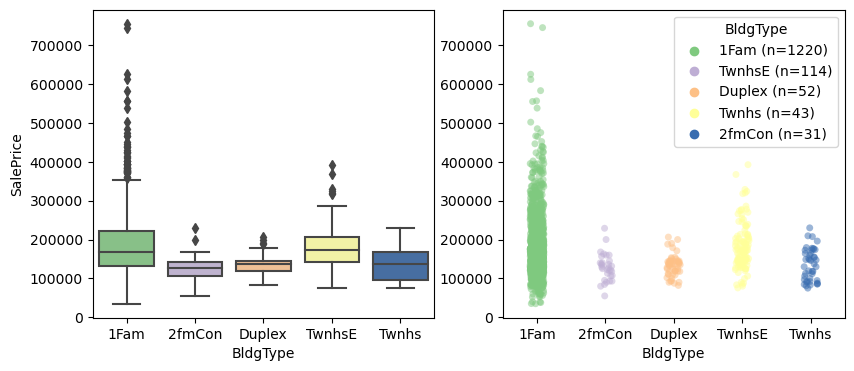

In [30]:
col_name = 'BldgType'
plot_cat_col(col_name)

In [31]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>HouseStyle</b><br>
Style of dwelling
	
1Story	One story<br>
1.5Fin	One and one-half story: 2nd level finished<br>
1.5Unf	One and one-half story: 2nd level unfinished<br>
2Story	Two story<br>
2.5Fin	Two and one-half story: 2nd level finished<br>
2.5Unf	Two and one-half story: 2nd level unfinished<br>
SFoyer	Split Foyer<br>
SLvl	Split Level

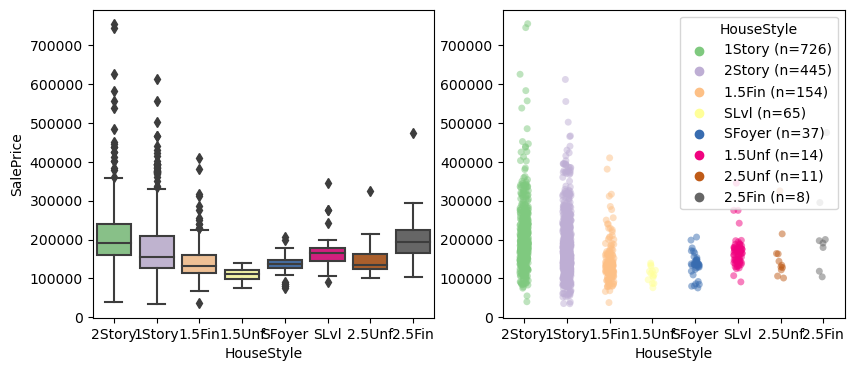

In [32]:
col_name = 'HouseStyle'
plot_cat_col(col_name)

In [33]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>RoofStyle</b>

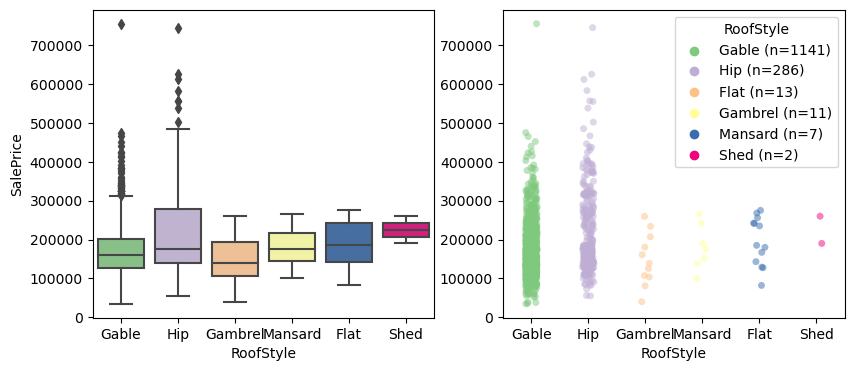

In [34]:
col_name = 'RoofStyle'
plot_cat_col(col_name)

In [35]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>RoofMatl</b>

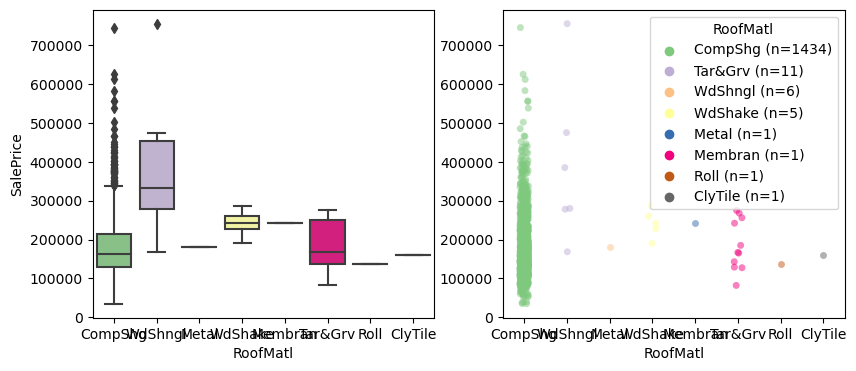

In [36]:
col_name = 'RoofMatl'
plot_cat_col(col_name)

In [37]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
cat_cols_tdrop.append(col_name)

##### <b>Exterior1st</b>

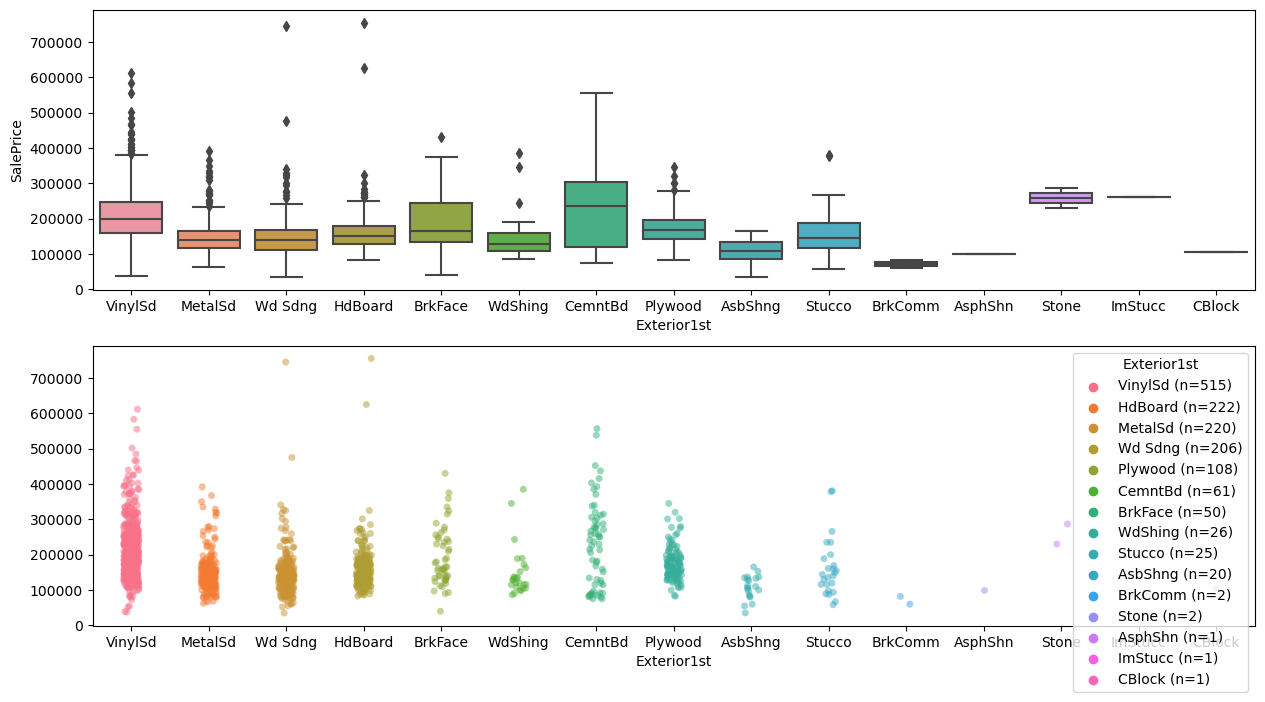

In [38]:
col_name = 'Exterior1st'
plot_cat_col(col_name, figsize=(15,8), sp1=2, sp2=1)

In [39]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>Exterior2nd</b>

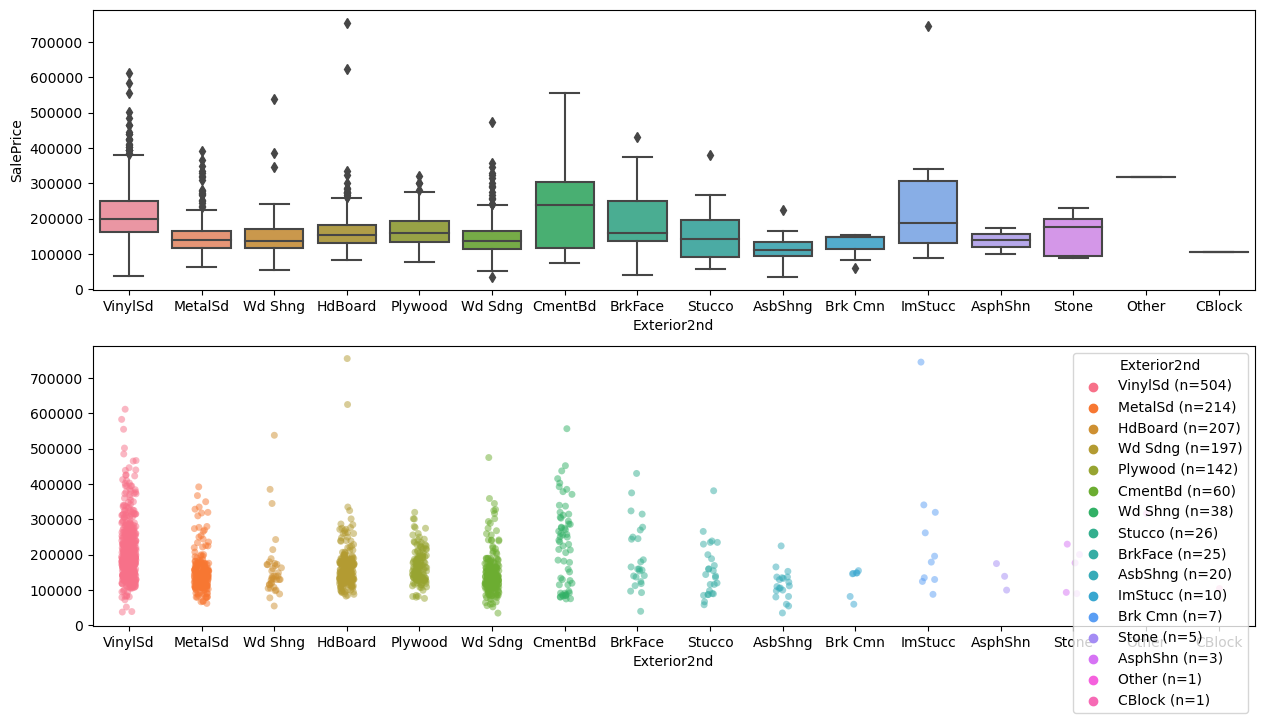

In [40]:
col_name = 'Exterior2nd'
plot_cat_col(col_name, figsize=(15,8), sp1=2, sp2=1)

In [41]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>MasVnrType</b>

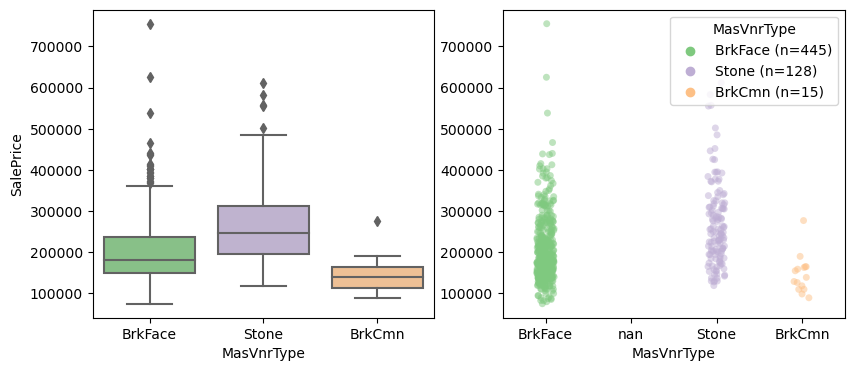

In [42]:
col_name = 'MasVnrType'
plot_cat_col(col_name)

In [43]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>ExterQual</b>

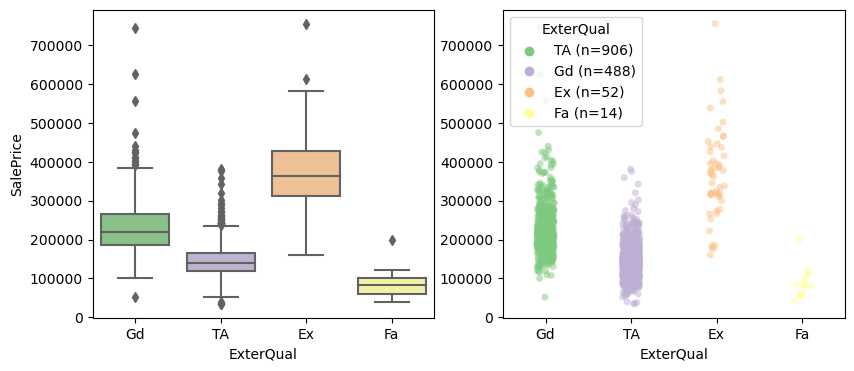

In [44]:
col_name = 'ExterQual'
plot_cat_col(col_name)

In [45]:
# cat_cols_oh.append(col_name)
cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>ExterCond</b>

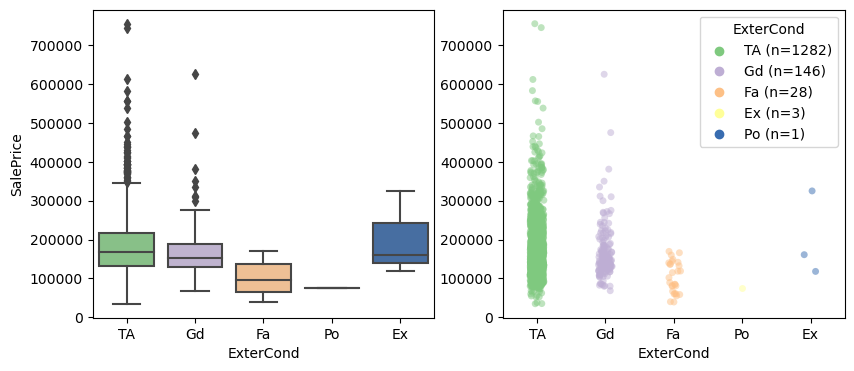

In [46]:
col_name = 'ExterCond'
plot_cat_col(col_name)

In [47]:
# cat_cols_oh.append(col_name)
cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>Foundation</b>

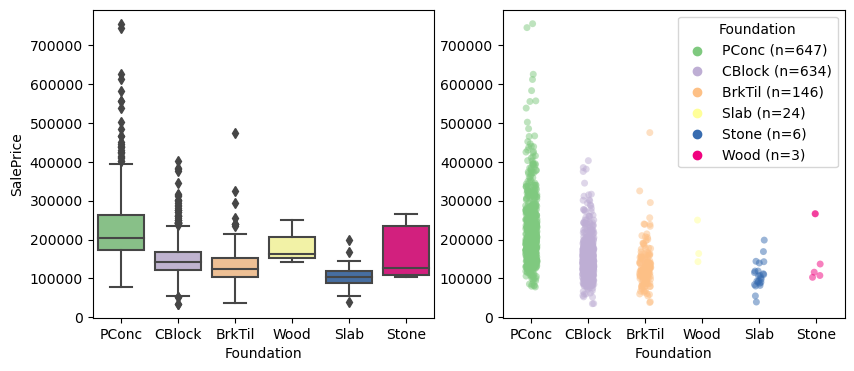

In [48]:
col_name = 'Foundation'
plot_cat_col(col_name)

In [49]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>BsmtQual</b>

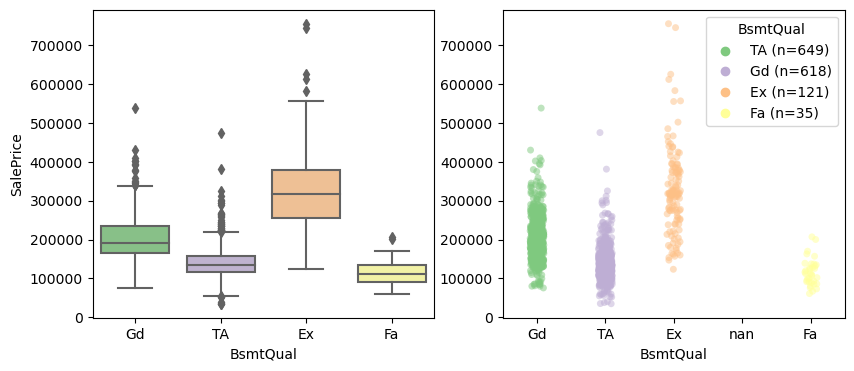

In [50]:
col_name = 'BsmtQual'
plot_cat_col(col_name)

In [51]:
# cat_cols_oh.append(col_name)
cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>BsmtCond</b>

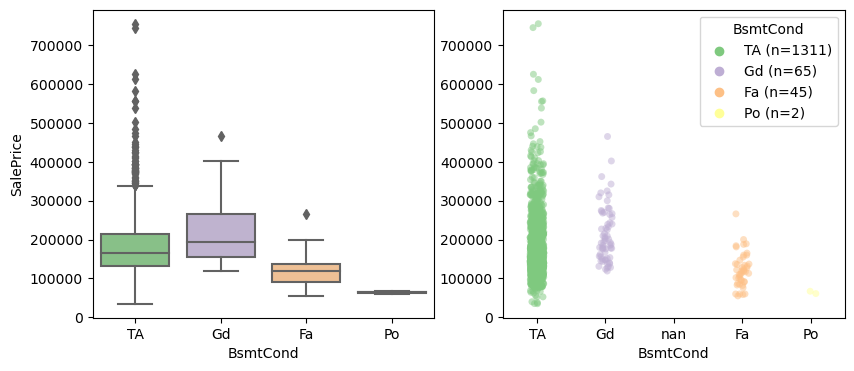

In [52]:
col_name = 'BsmtCond'
plot_cat_col(col_name)

In [53]:
# cat_cols_oh.append(col_name)
cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>BsmtExposure</b>
Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

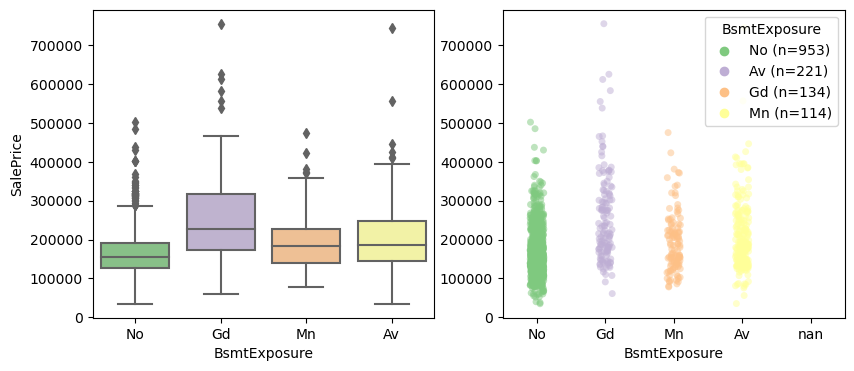

In [54]:
col_name = 'BsmtExposure'
plot_cat_col(col_name)

In [55]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>BsmtFinType1</b>

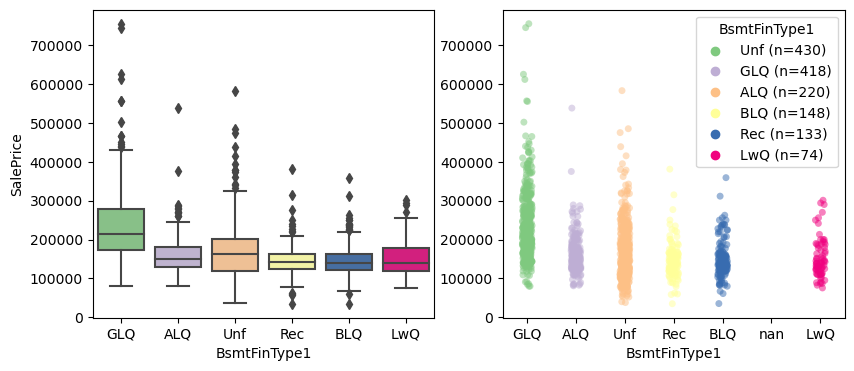

In [56]:
col_name = 'BsmtFinType1'
plot_cat_col(col_name)

In [57]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>BsmtFinType2</b>

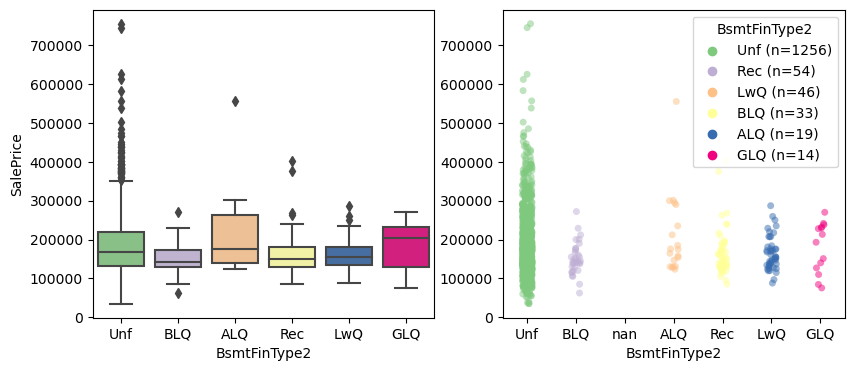

In [58]:
col_name = 'BsmtFinType2'
plot_cat_col(col_name)

In [59]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>Heating</b>

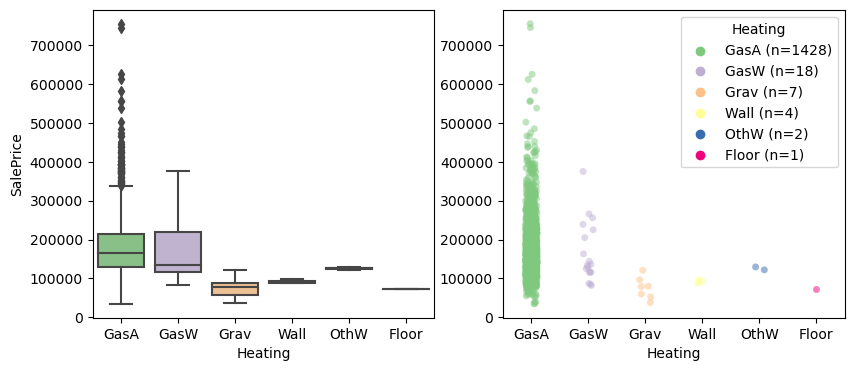

In [60]:
col_name = 'Heating'
plot_cat_col(col_name)

In [61]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>HeatingQC</b>

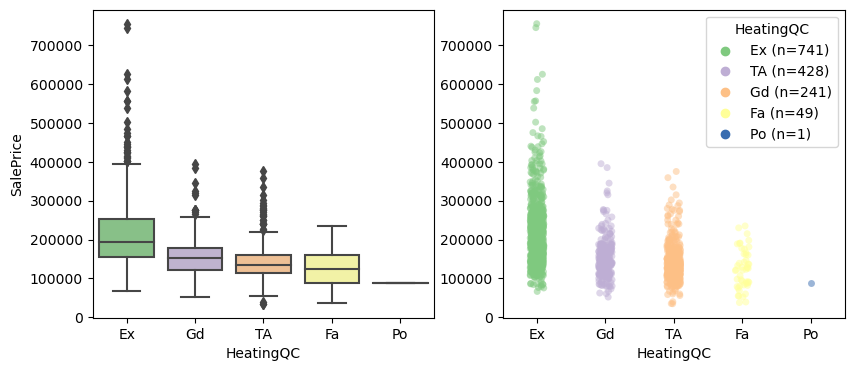

In [62]:
col_name = 'HeatingQC'
plot_cat_col(col_name)

In [63]:
# cat_cols_oh.append(col_name)
cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>CentralAir</b>

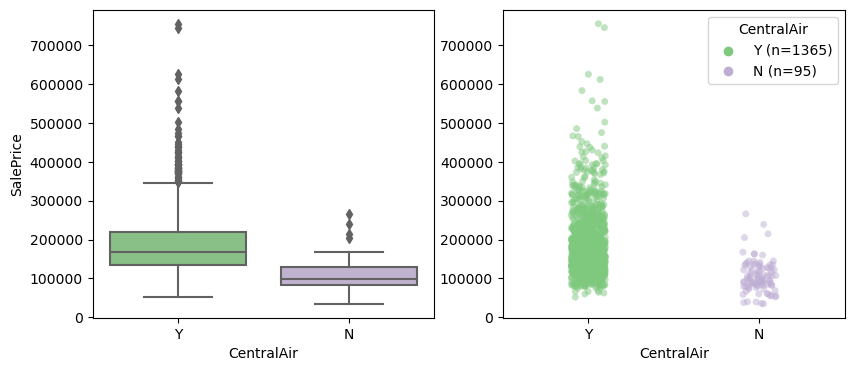

In [64]:
col_name = 'CentralAir'
plot_cat_col(col_name)

In [65]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>Electrical</b>

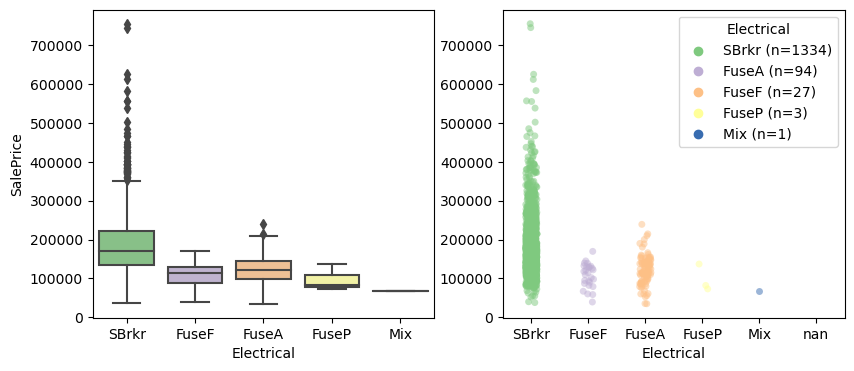

In [66]:
col_name = 'Electrical'
plot_cat_col(col_name)

In [67]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>KitchenQual</b>

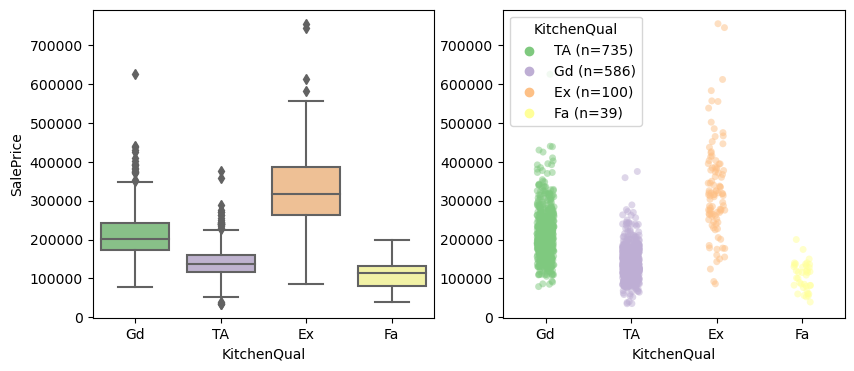

In [68]:
col_name = 'KitchenQual'
plot_cat_col(col_name)

In [69]:
# cat_cols_oh.append(col_name)
cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>Functional</b>

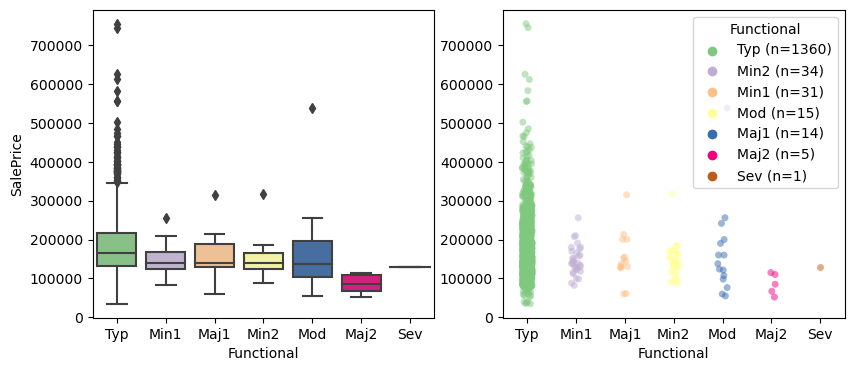

In [70]:
col_name = 'Functional'
plot_cat_col(col_name)

In [71]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>FireplaceQu</b>

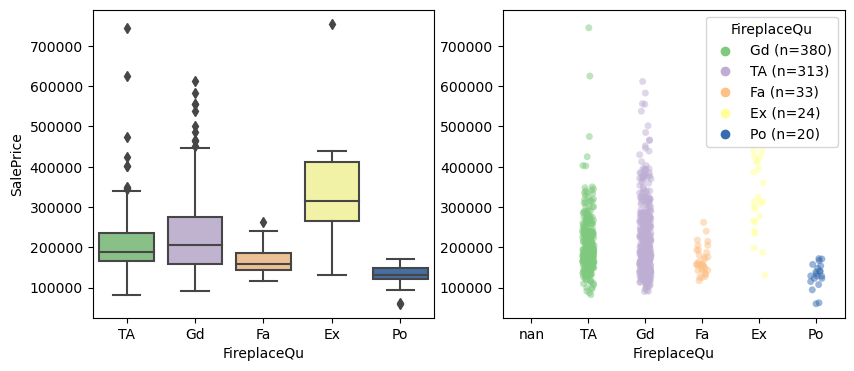

In [72]:
col_name = 'FireplaceQu'
plot_cat_col(col_name)

In [73]:
# cat_cols_oh.append(col_name)
cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>GarageType</b>

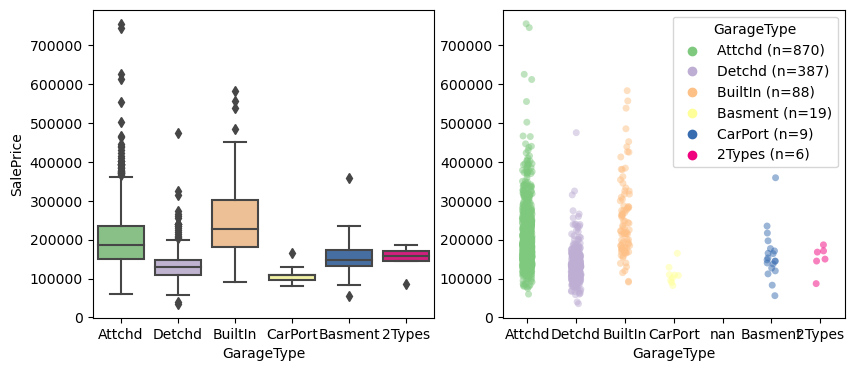

In [74]:
col_name = 'GarageType'
plot_cat_col(col_name)

In [75]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>GarageFinish</b>

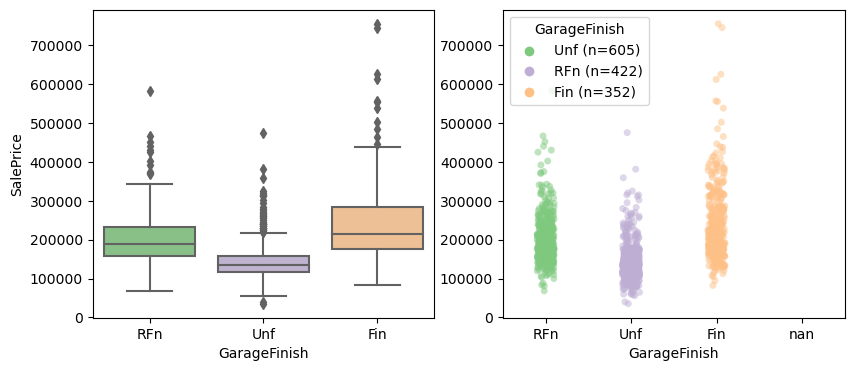

In [76]:
col_name = 'GarageFinish'
plot_cat_col(col_name)

In [77]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>GarageQual</b>

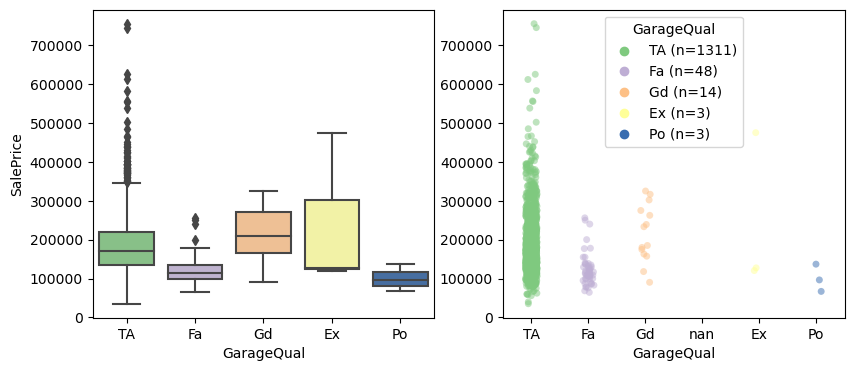

In [78]:
col_name = 'GarageQual'
plot_cat_col(col_name)

In [79]:
# cat_cols_oh.append(col_name)
cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>GarageCond</b>

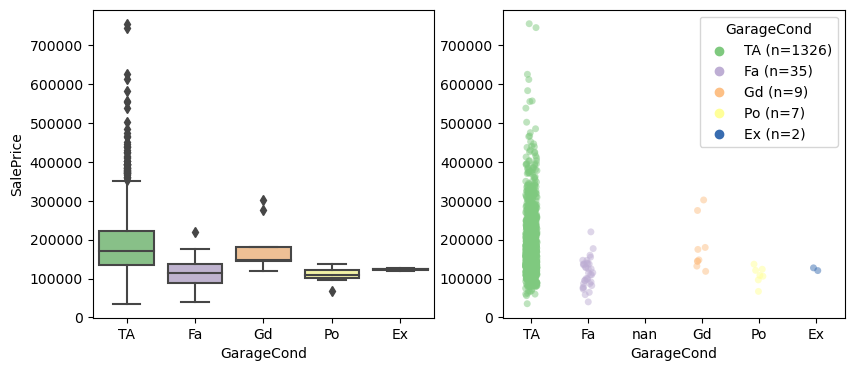

In [80]:
col_name = 'GarageCond'
plot_cat_col(col_name)

In [81]:
# cat_cols_oh.append(col_name)
cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>PavedDrive</b>

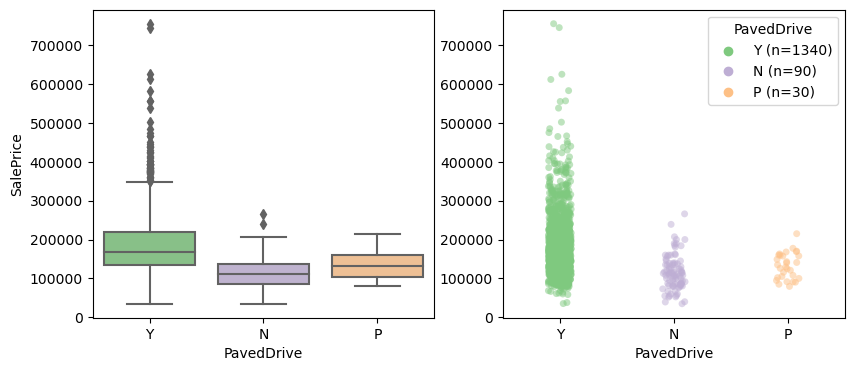

In [82]:
col_name = 'PavedDrive'
plot_cat_col(col_name)

In [83]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>PoolQC</b>

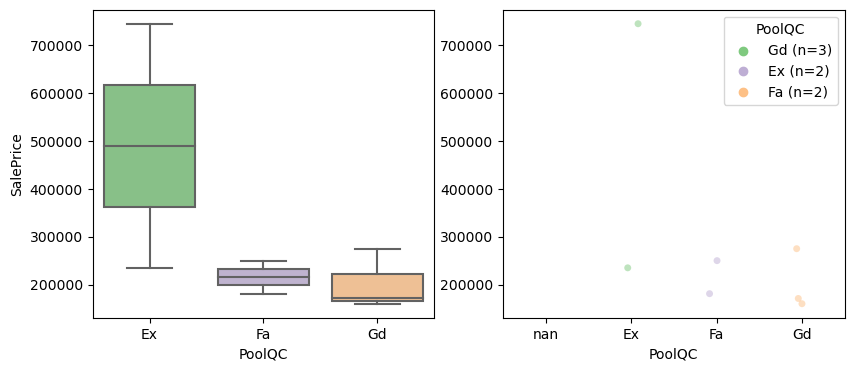

In [84]:
col_name = 'PoolQC'
plot_cat_col(col_name)

In [85]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
cat_cols_tdrop.append(col_name)

##### <b>Fence</b>

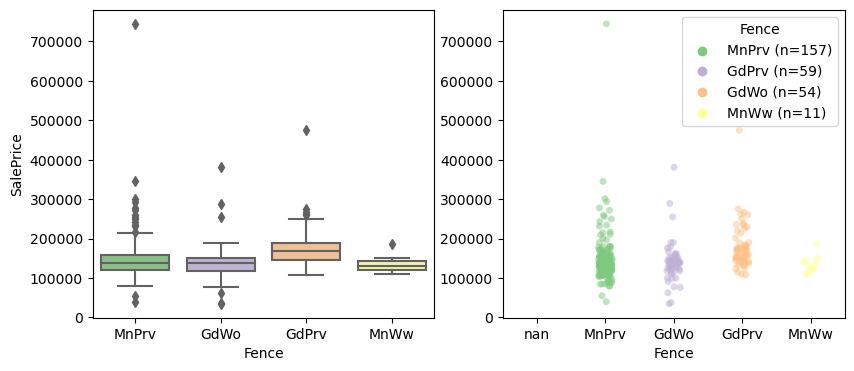

In [86]:
col_name = 'Fence'
plot_cat_col(col_name)

In [87]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>MiscFeature</b>

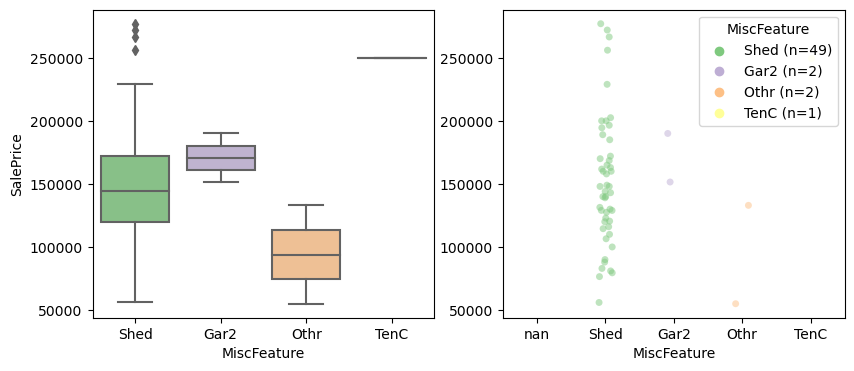

In [88]:
col_name = 'MiscFeature'
plot_cat_col(col_name)

In [89]:
#cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
cat_cols_tdrop.append(col_name)

##### <b>SaleType</b>

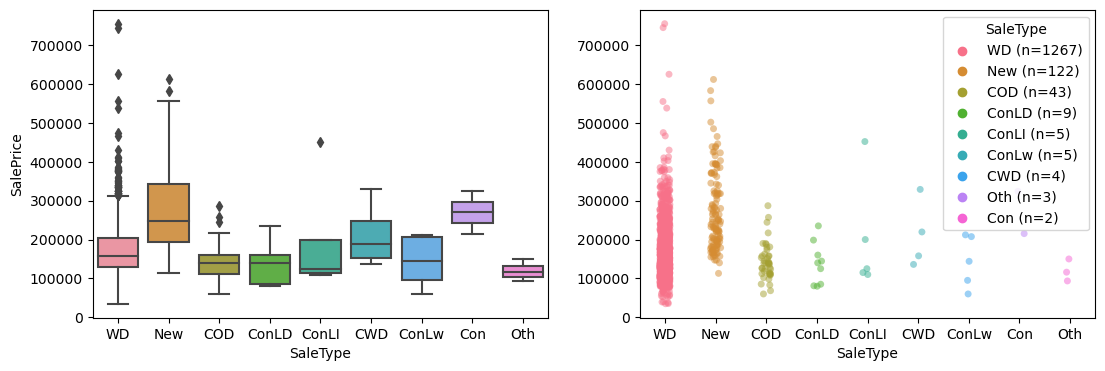

In [90]:
col_name = 'SaleType'
plot_cat_col(col_name, figsize=(20, 4))

In [91]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

##### <b>SaleCondition</b>
Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)

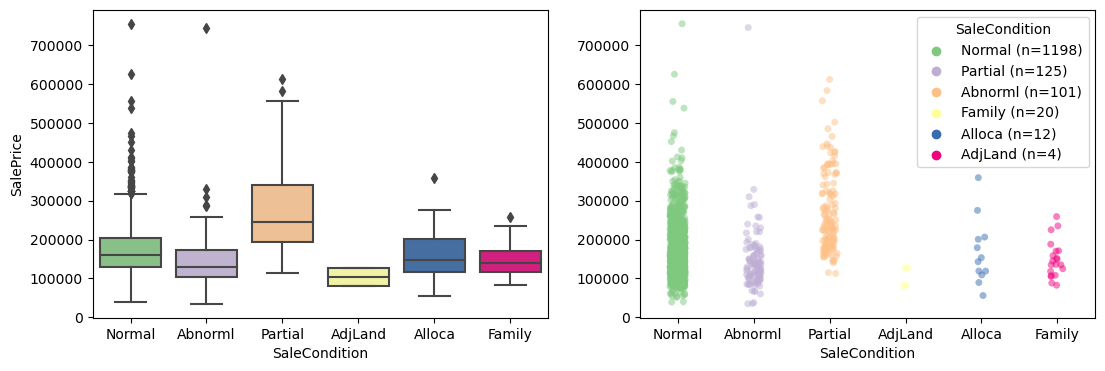

In [92]:
col_name = 'SaleCondition'
plot_cat_col(col_name, figsize=(20, 4))

In [93]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)

In [94]:
for l in [cat_cols_oe, cat_cols_oh, cat_cols_tdrop]:
    print(len(l))
    print(l)

9
['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
27
['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition']
7
['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'PoolQC', 'MiscFeature']


#### Numerical features transformation

In [95]:
print(len(df.dtypes[df.dtypes!='object'].index))

38


In [96]:
def plot_num_col(col_name, df=df, figsize=(15, 4), sp1=1, sp2=3):
    plt.figure(figsize=figsize)

    ax1 = plt.subplot(sp1, sp2, 1)
    sns.scatterplot(data=df, x=col_name, y='SalePrice', ax=ax1, label = "corr: %2f"%(df[col_name].corr(df['SalePrice'], method='spearman')),)

    ax2 = plt.subplot(sp1, sp2, 2)
    sns.histplot(data=df, x=col_name, ax=ax2, alpha=0.5)
    ax2.set_ylabel('')

    plt.show()

In [97]:
num_cols_norm, num_cols_asis, num_cols_tdrop, num_cols_flag = [], [], [], []

In [98]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
# num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)



##### <b>MSSubClass</b>
Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

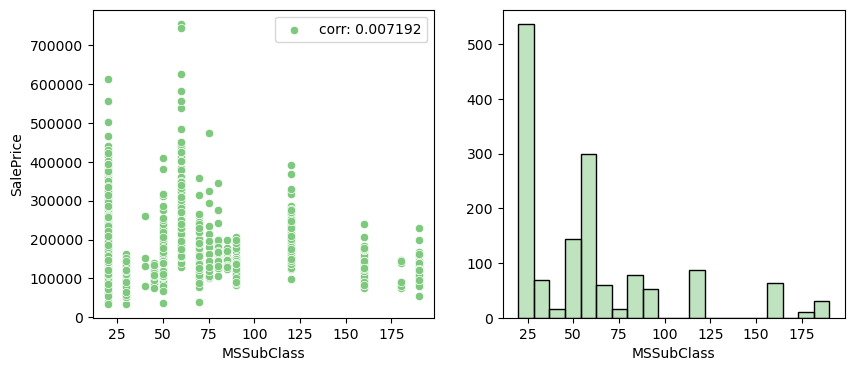

In [99]:
col_name ='MSSubClass'
plot_num_col(col_name)

The plots show that even though th dtype in the column is numerical, this feature is categorical

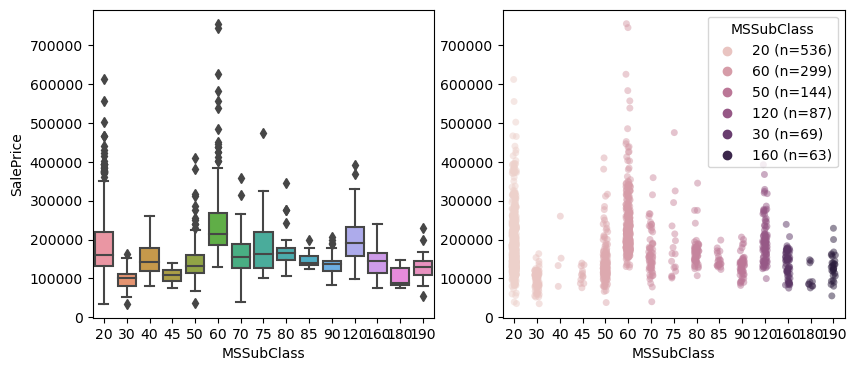

In [100]:
plot_cat_col(col_name)

We will create dummy variables for it

In [101]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
# num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)

##### <b>LotFrontage</b>

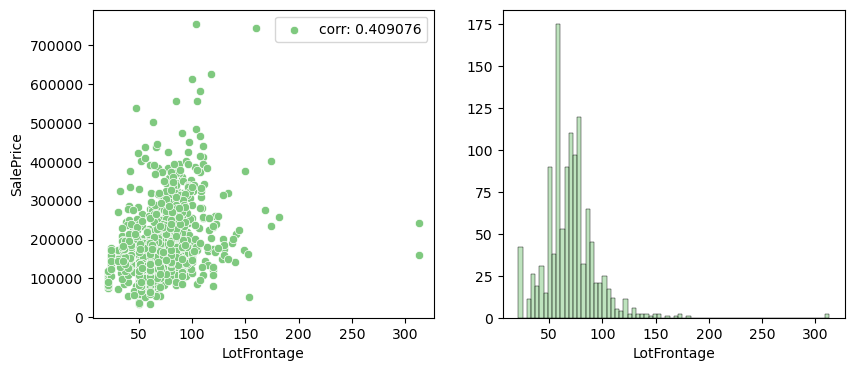

In [102]:
col_name ='LotFrontage'
plot_num_col(col_name)

In [103]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)

##### <b>LotArea</b>

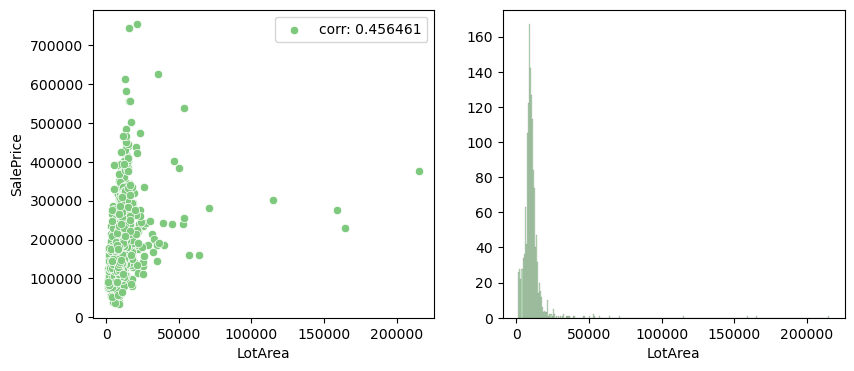

In [104]:
col_name ='LotArea'
plot_num_col(col_name)

In [105]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)

##### <b>OverallQual</b>

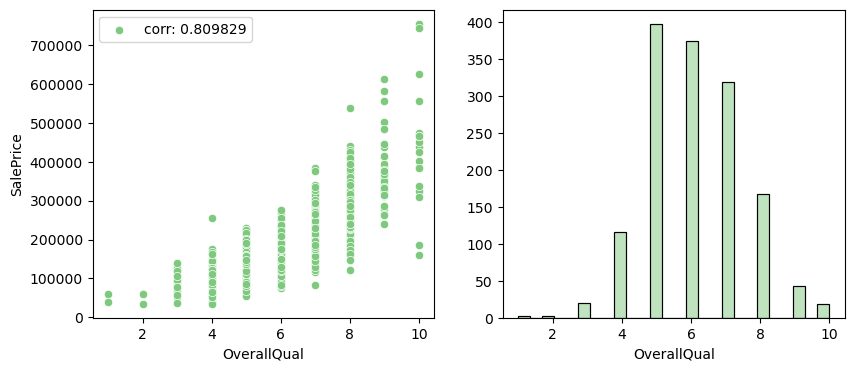

In [106]:
col_name ='OverallQual'
plot_num_col(col_name)

In [107]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
# num_cols_norm.append(col_name)
num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)

##### <b>OverallCond</b>

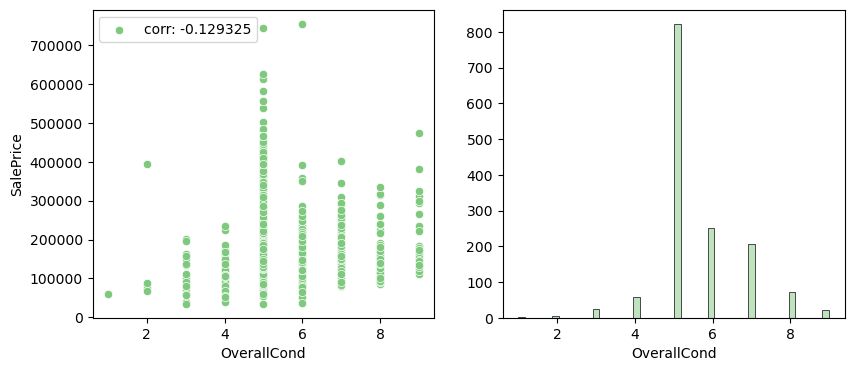

In [108]:
col_name ='OverallCond'
plot_num_col(col_name)

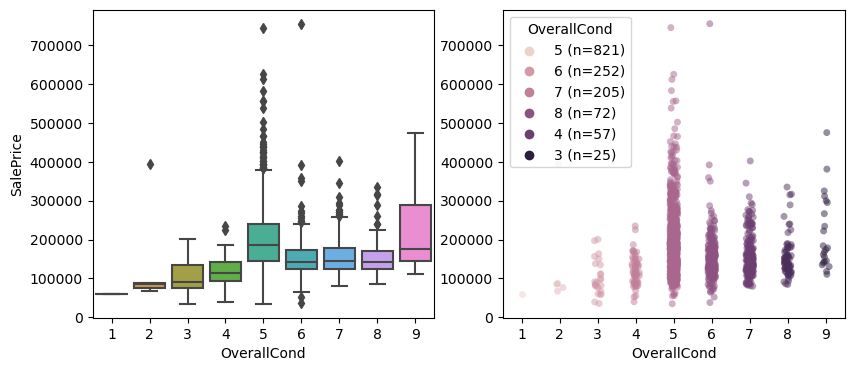

In [109]:
plot_cat_col(col_name)

In [110]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
# num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)

##### <b>YearBuilt</b>

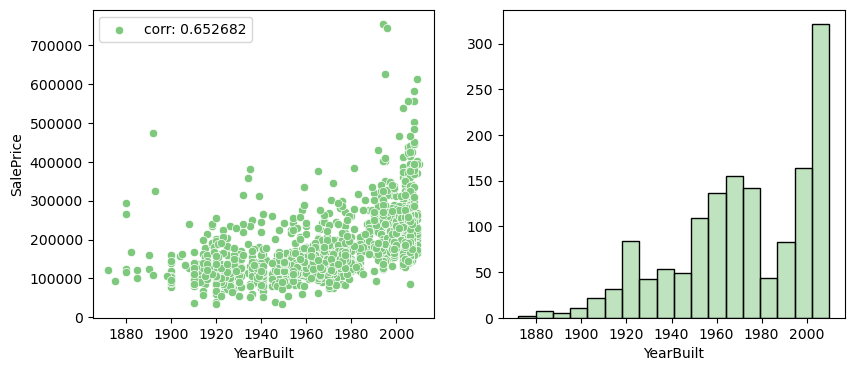

In [111]:
col_name ='YearBuilt'
plot_num_col(col_name)

In [112]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)

##### <b>YearRemodAdd</b>

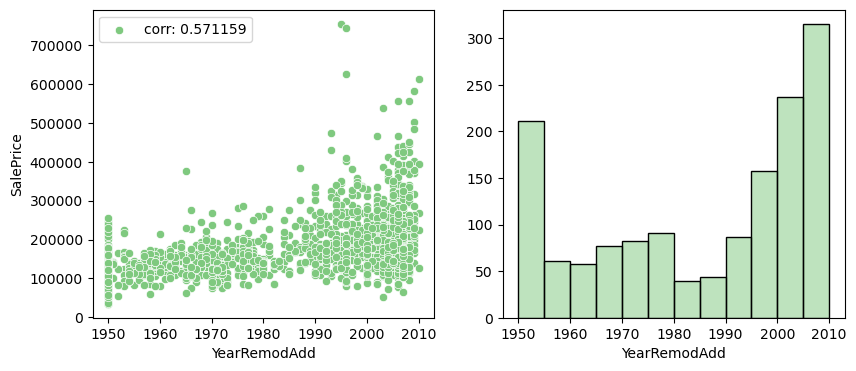

In [113]:
col_name ='YearRemodAdd'
plot_num_col(col_name)

In [114]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)

##### <b>MasVnrArea</b>
Masonry veneer area in square feet

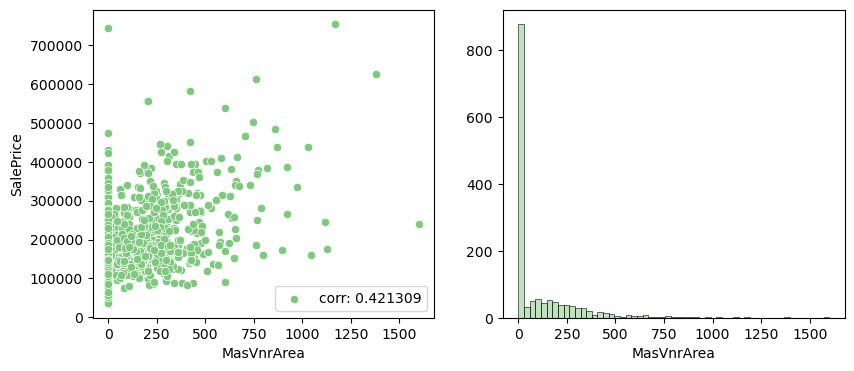

In [115]:
col_name ='MasVnrArea'
plot_num_col(col_name)

In [116]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)

##### <b>BsmtFinSF1</b>

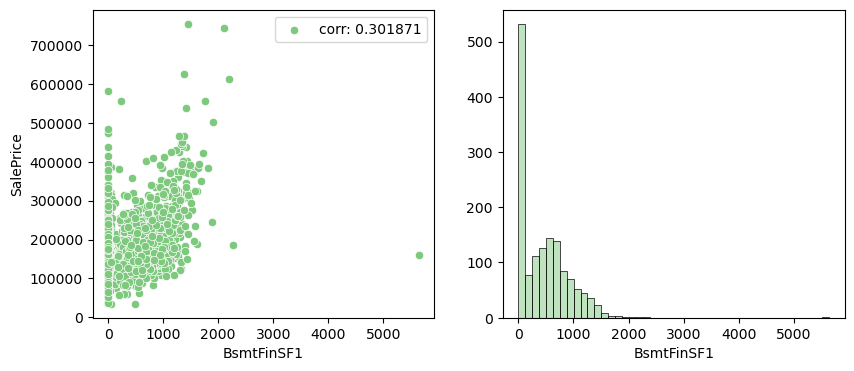

In [117]:
col_name ='BsmtFinSF1'
plot_num_col(col_name)

In [118]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)

##### <b>BsmtFinSF2</b>
Type 2 finished square feet

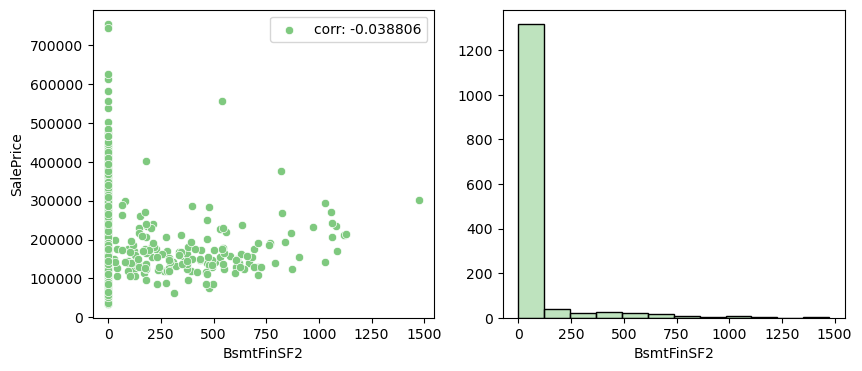

In [119]:
col_name ='BsmtFinSF2'
plot_num_col(col_name)

In [120]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
# num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
num_cols_flag.append(col_name)

##### <b>BsmtUnfSF</b>

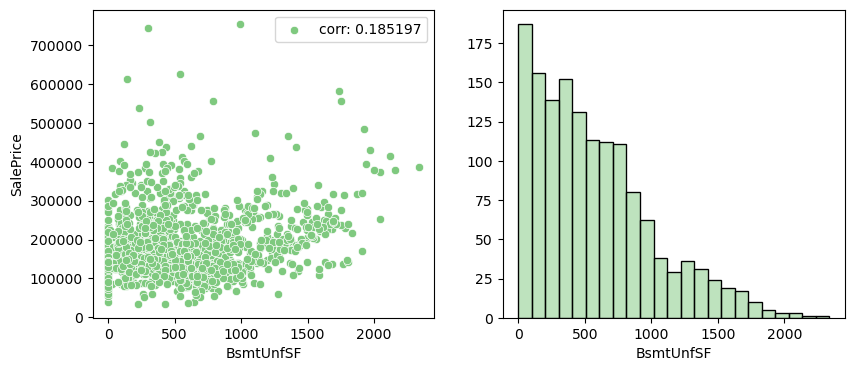

In [121]:
col_name ='BsmtUnfSF'
plot_num_col(col_name)

In [122]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)

##### <b>TotalBsmtSF</b>

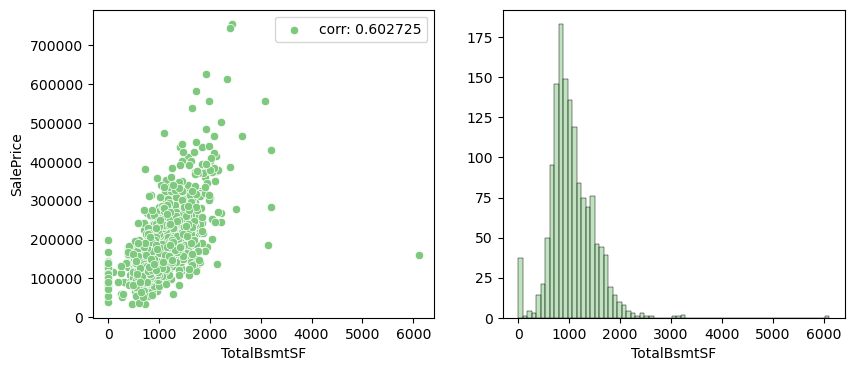

In [123]:
col_name ='TotalBsmtSF'
plot_num_col(col_name)

In [124]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)

##### <b>1stFlrSF</b>

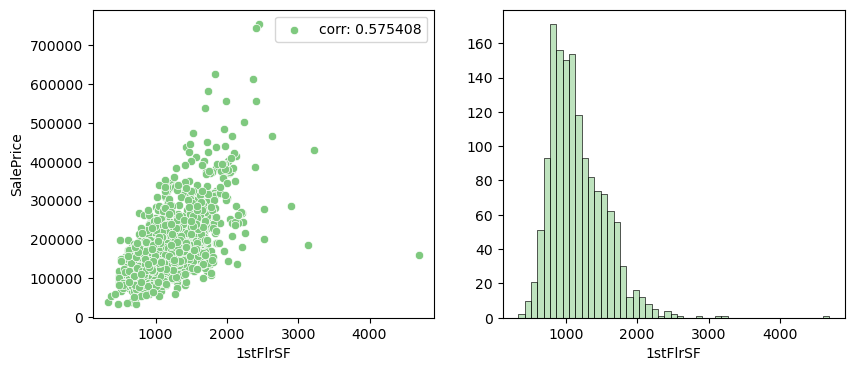

In [125]:
col_name ='1stFlrSF'
plot_num_col(col_name)

In [126]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)

##### <b>2ndFlrSF</b>

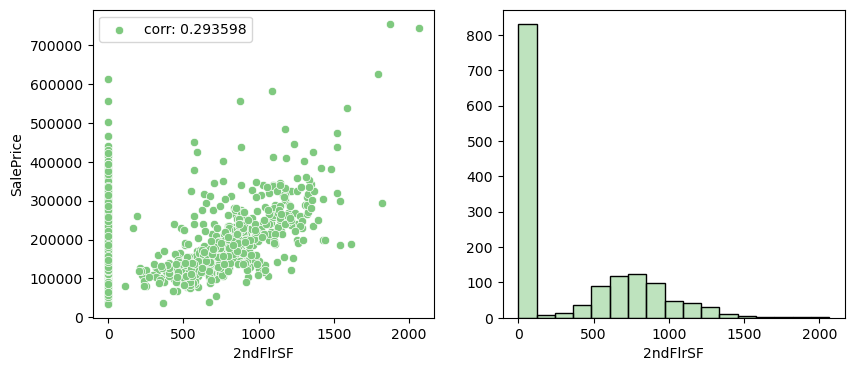

In [127]:
col_name ='2ndFlrSF'
plot_num_col(col_name)

In [128]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)

##### <b>LowQualFinSF</b>

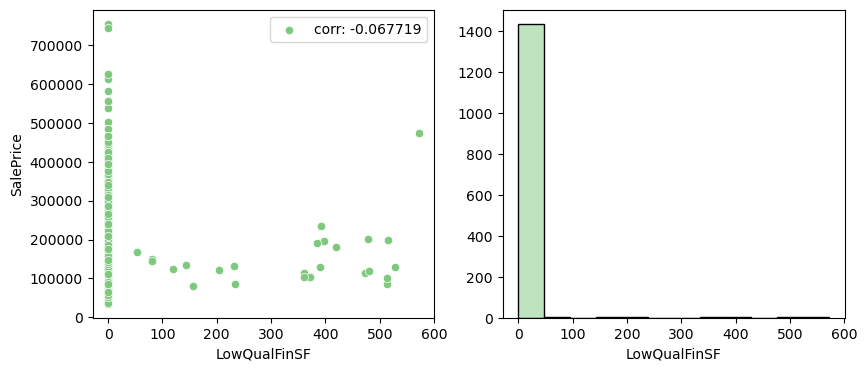

In [129]:
col_name ='LowQualFinSF'
plot_num_col(col_name)

In [130]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
# num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
num_cols_flag.append(col_name)

##### <b>GrLivArea</b>

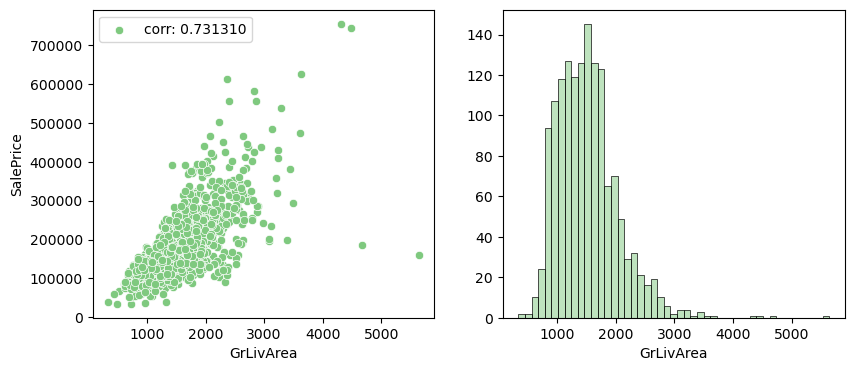

In [131]:
col_name ='GrLivArea'
plot_num_col(col_name)

In [132]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)

##### <b>BsmtFullBath</b>

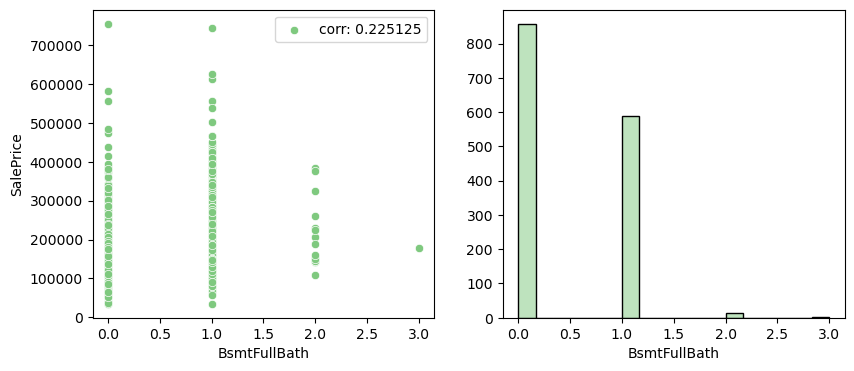

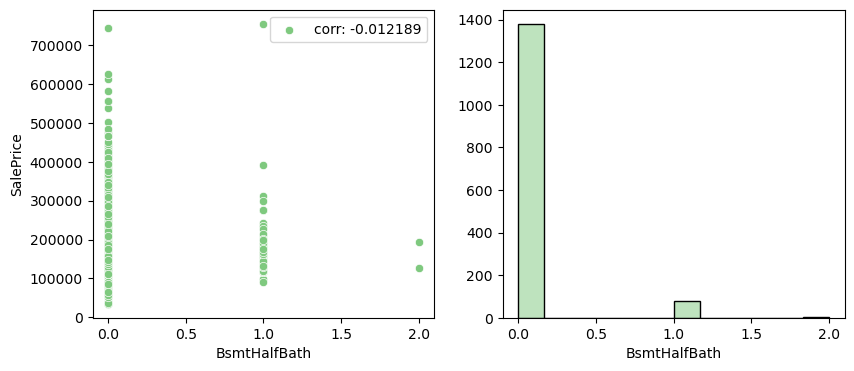

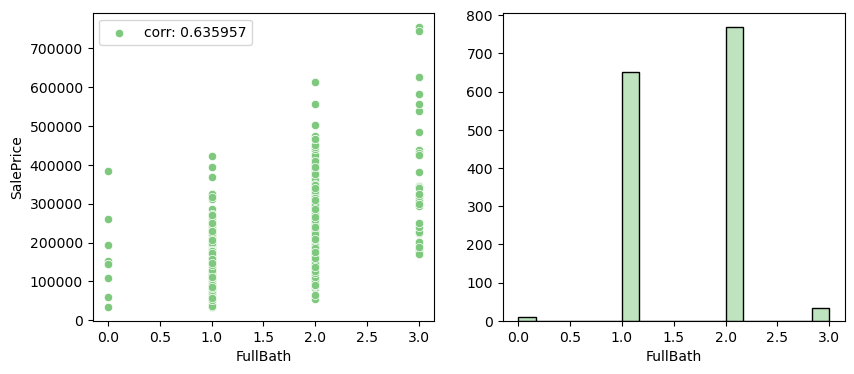

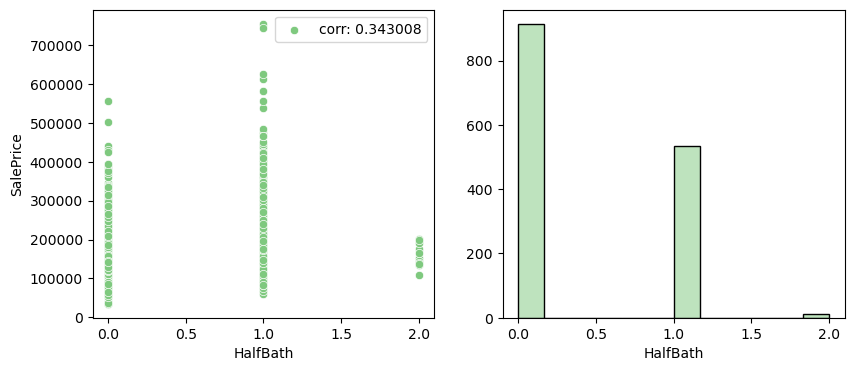

In [133]:
col_name =['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']

for cb in col_name:
    plot_num_col(cb)

In [136]:
for i in range(4):
    if i ==0:
        tdf['Bath'] = tdf[col_name[i]] * df[col_name[i]].corr(df['SalePrice'], method='spearman')
        print(df[col_name[i]].corr(df['SalePrice'], method='spearman'))
    else:
        tdf['Bath'] += tdf[col_name[i]] * df[col_name[i]].corr(df['SalePrice'], method='spearman')
        print(df[col_name[i]].corr(df['SalePrice'], method='spearman'))

0.22512486719612368
-0.012188876310787316
0.6359570562496957
0.34300754918568294


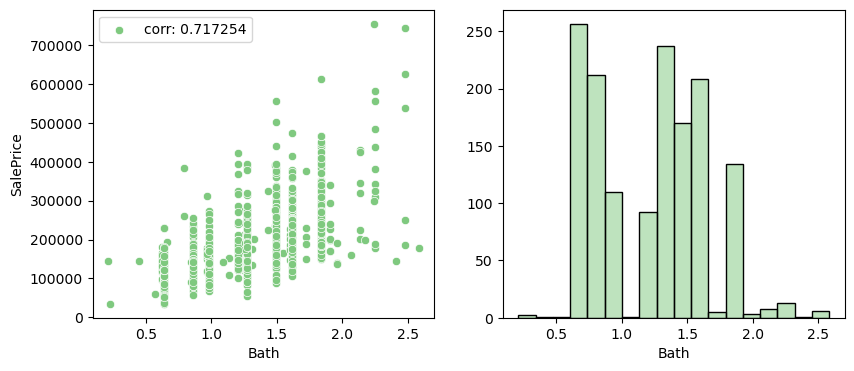

In [137]:
plot_num_col('Bath', df=tdf)

In [138]:
for cb in col_name:
    num_cols_tdrop.append(cb)

##### <b>BedroomAbvGr</b>

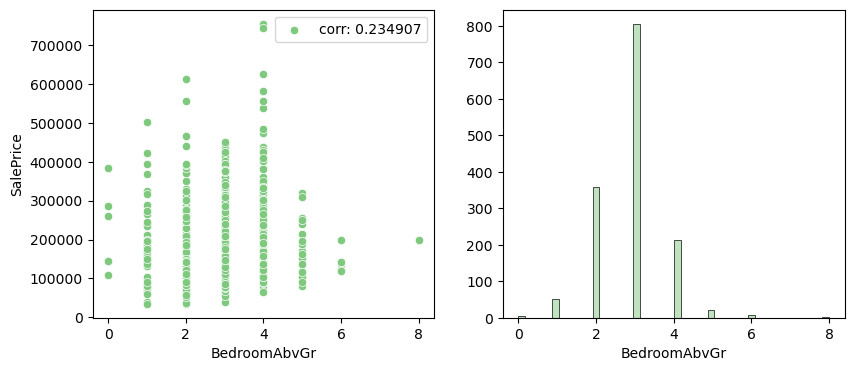

In [139]:
col_name ='BedroomAbvGr'
plot_num_col(col_name)

In [140]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
# num_cols_norm.append(col_name)
num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)

##### <b>KitchenAbvGr</b>

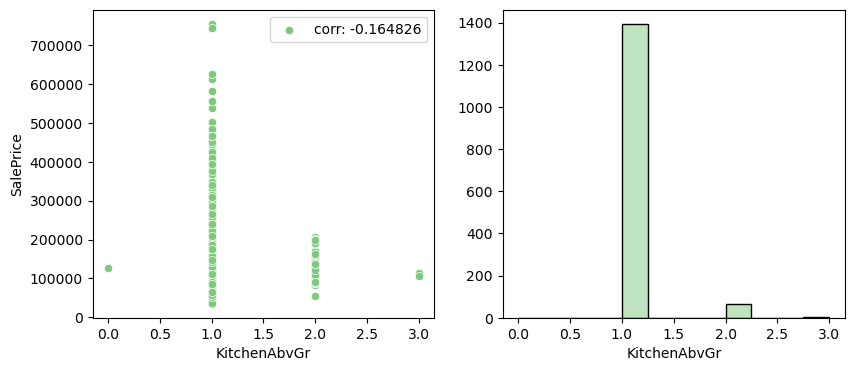

In [141]:
col_name ='KitchenAbvGr'
plot_num_col(col_name)

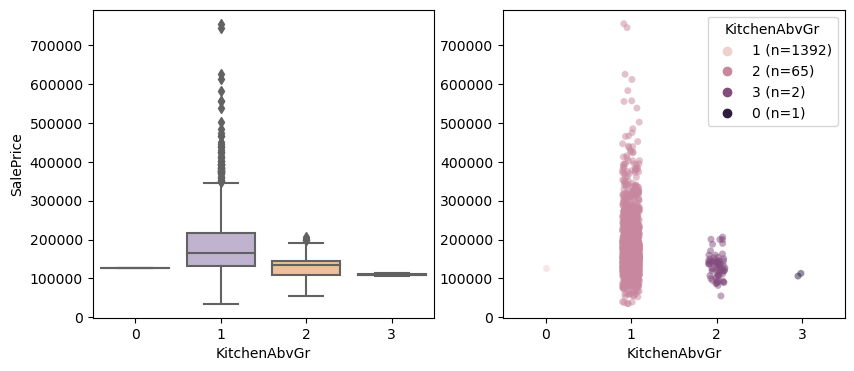

In [142]:
plot_cat_col(col_name)

In [143]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
# num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)

##### <b>TotRmsAbvGrd</b>

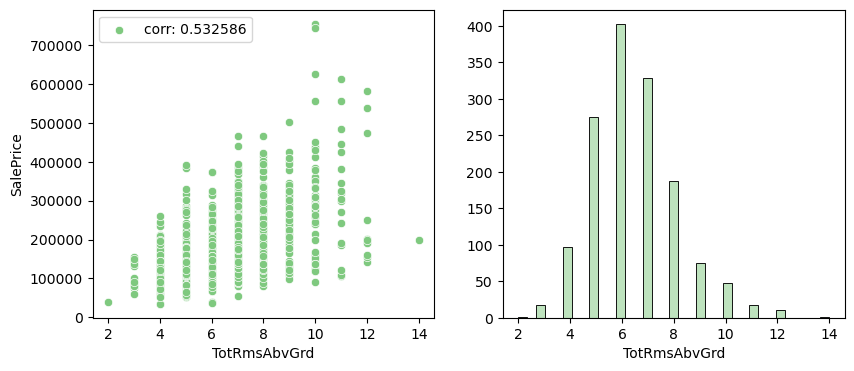

In [144]:
col_name ='TotRmsAbvGrd'
plot_num_col(col_name)

In [145]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
# num_cols_norm.append(col_name)
num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)

##### <b>Fireplaces</b>

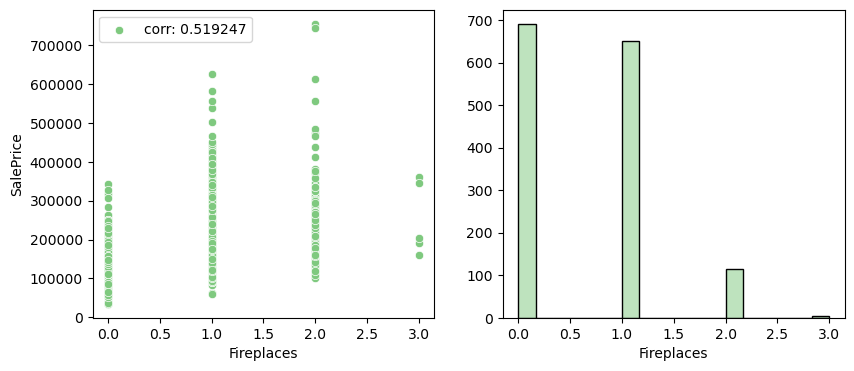

In [146]:
col_name ='Fireplaces'
plot_num_col(col_name)

In [147]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
# num_cols_norm.append(col_name)
num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)

##### <b>GarageYrBlt</b>

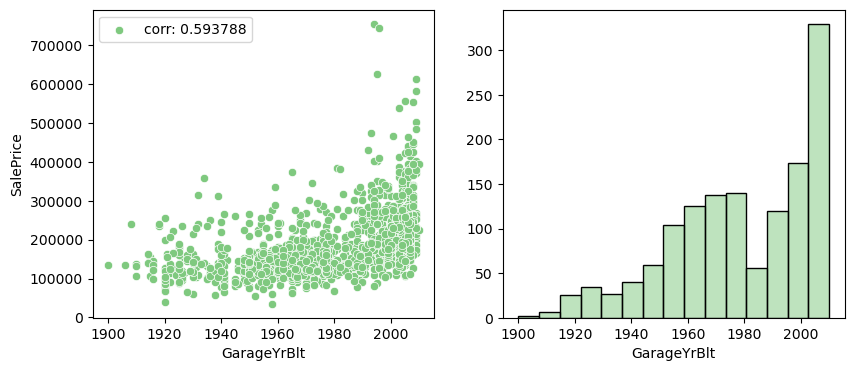

In [148]:
col_name ='GarageYrBlt'
plot_num_col(col_name)

In [149]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)

##### <b>GarageCars</b>

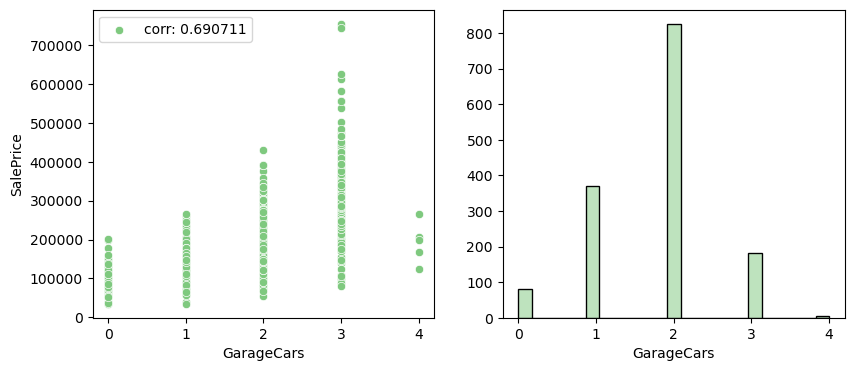

In [150]:
col_name ='GarageCars'
plot_num_col(col_name)

In [151]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
# num_cols_norm.append(col_name)
num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)

##### <b>GarageArea</b>

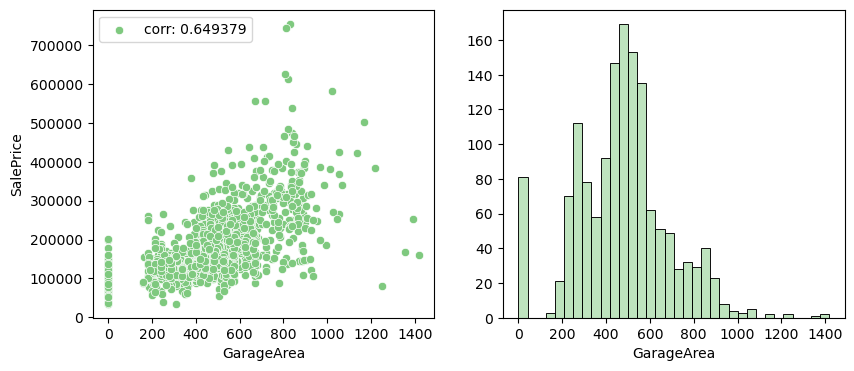

In [152]:
col_name ='GarageArea'
plot_num_col(col_name)

In [153]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)

##### <b>WoodDeckSF</b>

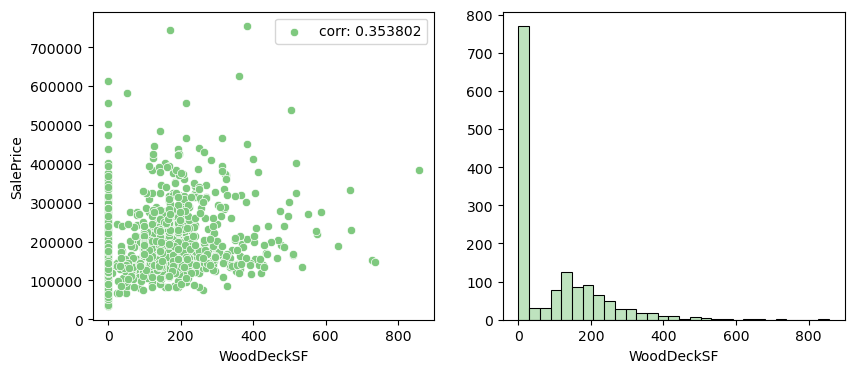

In [154]:
col_name ='WoodDeckSF'
plot_num_col(col_name)

In [155]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)

##### <b>OpenPorchSF</b>

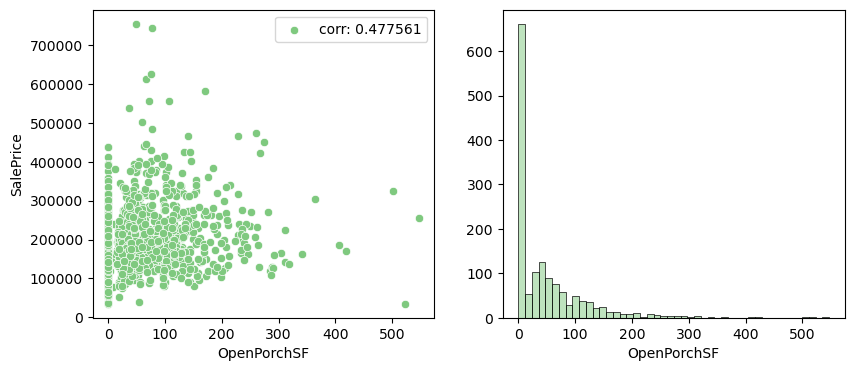

In [156]:
col_name ='OpenPorchSF'
plot_num_col(col_name)

In [157]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)

##### <b>EnclosedPorch</b>

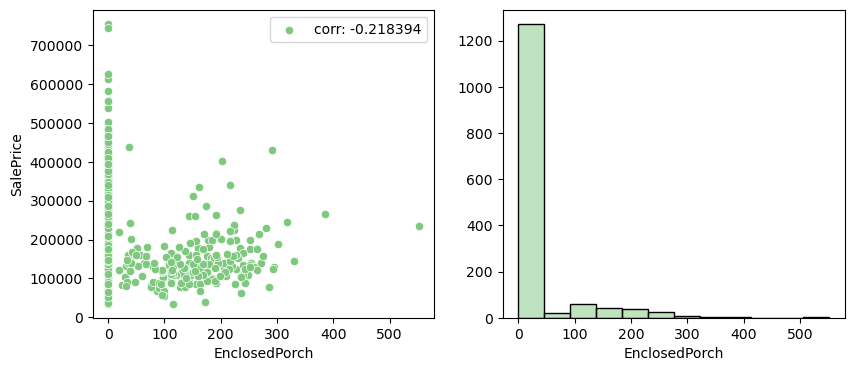

In [158]:
col_name ='EnclosedPorch'
plot_num_col(col_name)

##### <b>3SsnPorch</b>

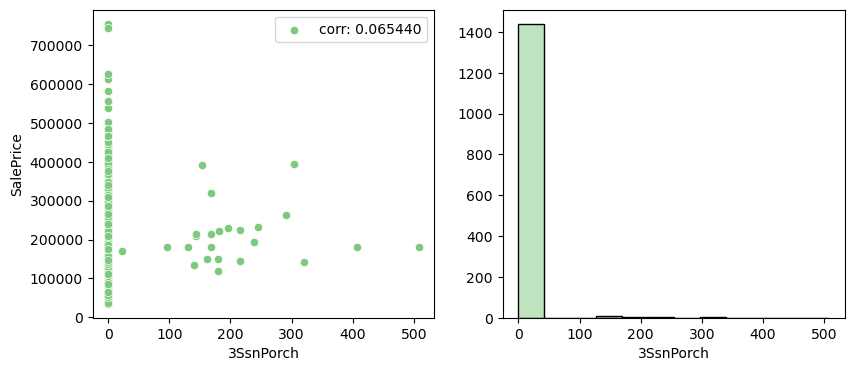

In [159]:
col_name ='3SsnPorch'
plot_num_col(col_name)

In [160]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
# num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
num_cols_flag.append(col_name)

##### <b>ScreenPorch</b>

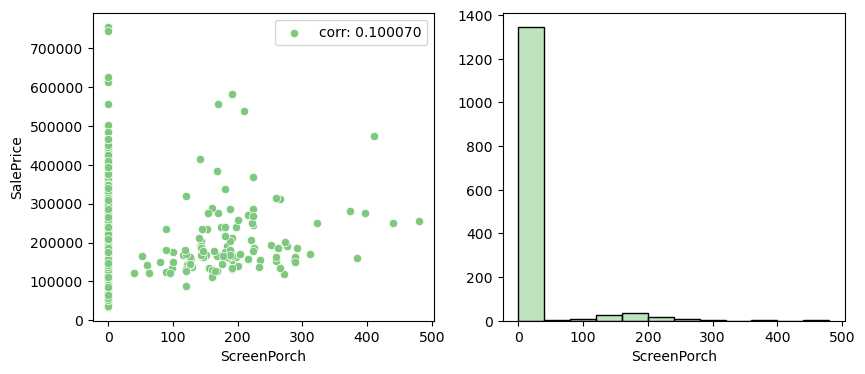

In [161]:
col_name ='ScreenPorch'
plot_num_col(col_name)

In [162]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
# num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)

##### <b>PoolArea</b>

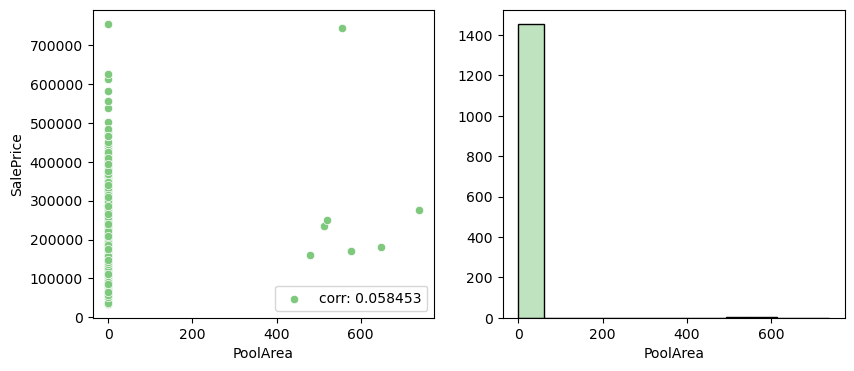

In [163]:
col_name ='PoolArea'
plot_num_col(col_name)

In [164]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
# num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
num_cols_flag.append(col_name)

##### <b>MiscVal</b>
MiscVal: $Value of miscellaneous feature

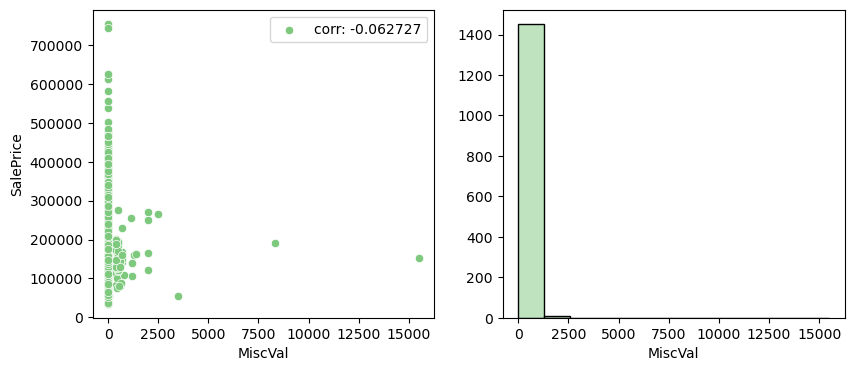

In [165]:
col_name ='MiscVal'
plot_num_col(col_name)

In [166]:
# cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
cat_cols_tdrop.append(col_name)
# num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)

##### <b>MoSold</b>

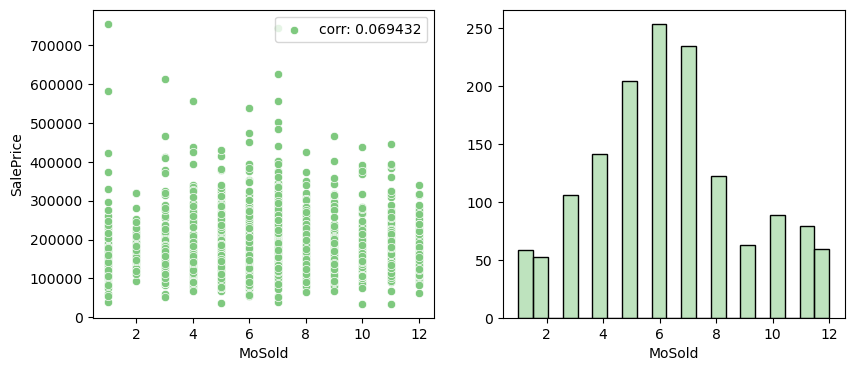

In [167]:
col_name ='MoSold'
plot_num_col(col_name)

In [168]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
# num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)

##### <b>YrSold</b>

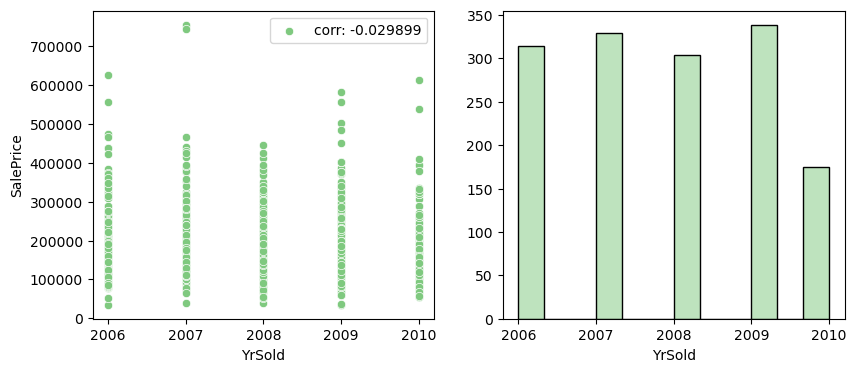

In [169]:
col_name ='YrSold'
plot_num_col(col_name)

In [170]:
cat_cols_oh.append(col_name)
# cat_cols_oe.append(col_name)
# cat_cols_tdrop.append(col_name)
# num_cols_norm.append(col_name)
# num_cols_asis.append(col_name)
# num_cols_tdrop.append(col_name)
# num_cols_flag.append(col_name)

##### <b>SalePrice</b>

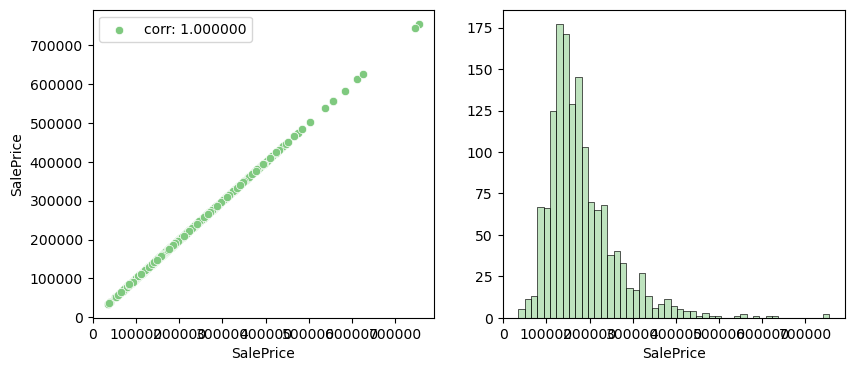

In [171]:
col_name ='SalePrice'
plot_num_col(col_name)

##### <b></b>

In [175]:
fl = 0
for l in [cat_cols_oe, cat_cols_oh, cat_cols_tdrop, num_cols_norm, num_cols_asis, num_cols_tdrop, num_cols_flag]:
    print(len(l))
    print(l)
    fl += len(l)
print(fl)


9
['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
32
['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition', 'MSSubClass', 'OverallCond', 'KitchenAbvGr', 'MoSold', 'YrSold']
8
['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'PoolQC', 'MiscFeature', 'MiscVal']
15
['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']
5
['OverallQual', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars']
4
['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 

In [173]:
print(len(df.columns))

81


In [176]:
# Scale values
scaler = StandardScaler()
tdf[num_cols_norm] = scaler.fit_transform(tdf[num_cols_norm] )

In [177]:
tdf[num_cols_norm] 

LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
0       -0.208034 -0.207142   1.050994      0.878668    0.510015    0.575425   
1        0.409895 -0.091886   0.156734     -0.429577   -0.572835    1.171992   
2       -0.084449  0.073480   0.984752      0.830215    0.322174    0.092907   
3       -0.414011 -0.096897  -1.863632     -0.720298   -0.572835   -0.499274   
4        0.574676  0.375148   0.951632      0.733308    1.360826    0.463568   
...           ...       ...        ...           ...         ...         ...   
1455    -0.331620 -0.260560   0.918511      0.733308   -0.572835   -0.973018   
1456     0.615871  0.266407   0.222975      0.151865    0.084610    0.759659   
1457    -0.166839 -0.147810  -1.002492      1.024029   -0.572835   -0.369871   
1458    -0.084449 -0.080160  -0.704406      0.539493   -0.572835   -0.865548   
1459     0.203918 -0.058112  -0.207594     -0.962566   -0.572835    0.847389   

      BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  GarageYrBlt  \
0     -0.944591    -0.459303 -0.793434  1.161852   0.370333     0.992426   
1     -0.641228     0.466465  0.257140 -0.795163  -0.482512    -0.101543   
2     -0.301643    -0.313369 -0.627826  1.189351   0.515013     0.911391   
3     -0.061670    -0.687324 -0.521734  0.937276   0.383659     0.789839   
4     -0.174865     0.199680 -0.045611  1.617877   1.299326     0.870874   
...         ...          ...       ...       ...        ...          ...   
1455   0.873321    -0.238122 -0.542435  0.795198   0.250402     0.830356   
1456   0.049262     1.104925  2.355701 -0.795163   1.061367    -0.020508   
1457   0.701265     0.215641  0.065656  1.844744   1.569647    -1.519651   
1458  -1.284176     0.046905 -0.218982 -0.795163  -0.832788    -1.154995   
1459  -0.976285     0.452784  0.241615 -0.795163  -0.493934    -0.547234   

      GarageArea  WoodDeckSF  OpenPorchSF  
0       0.351000   -0.752176     0.216503  
1      -0.060731    1.626195    -0.704483  
2       0.631726   -0.752176    -0.070361  
3       0.790804   -0.752176    -0.176048  
4       1.698485    0.780197     0.563760  
...          ...         ...          ...  
1455   -0.060731   -0.752176    -0.100558  
1456    0.126420    2.033231    -0.704483  
1457   -1.033914   -0.752176     0.201405  
1458   -1.090059    2.168910    -0.704483  
1459   -0.921624    5.121921     0.322190  

[1460 rows x 15 columns]

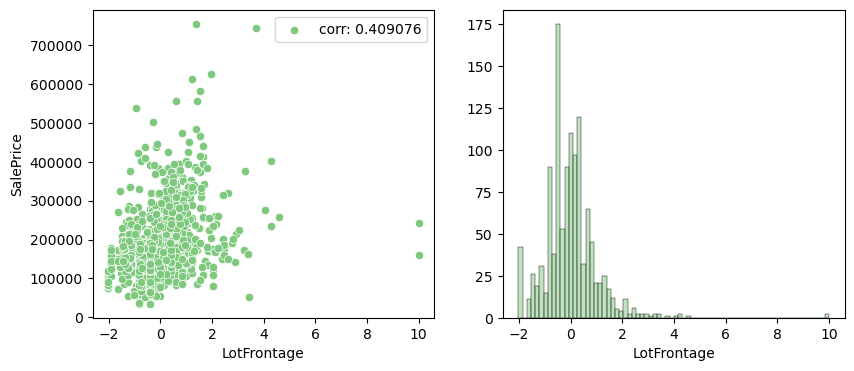

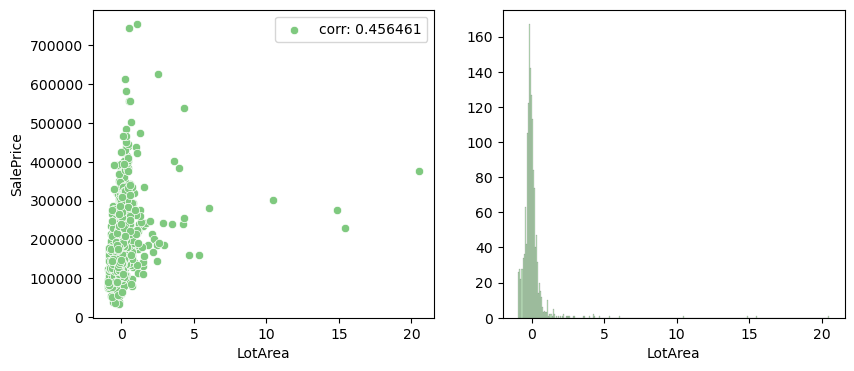

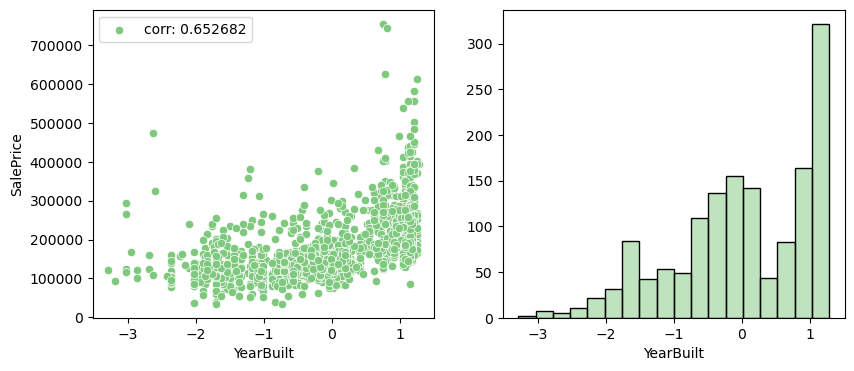

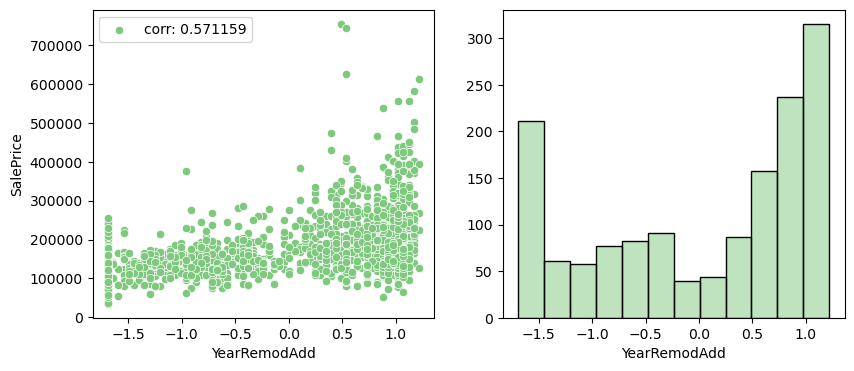

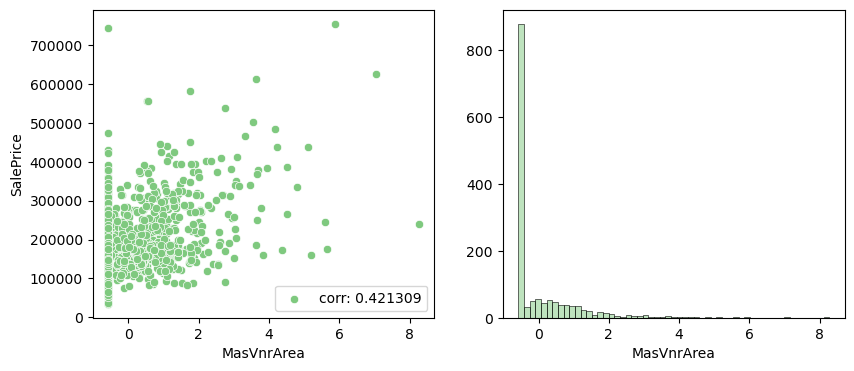

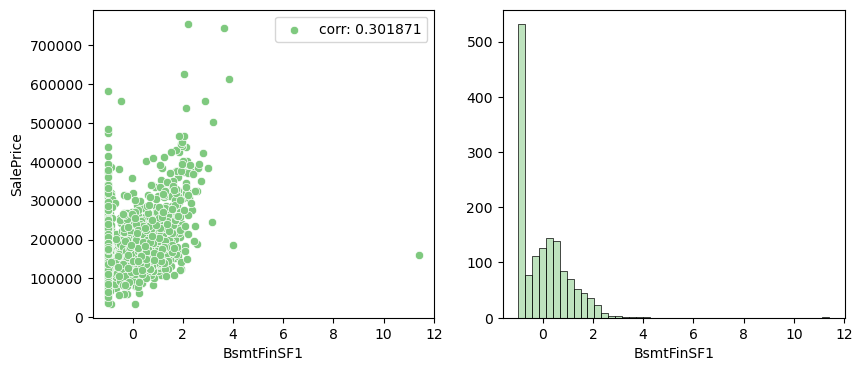

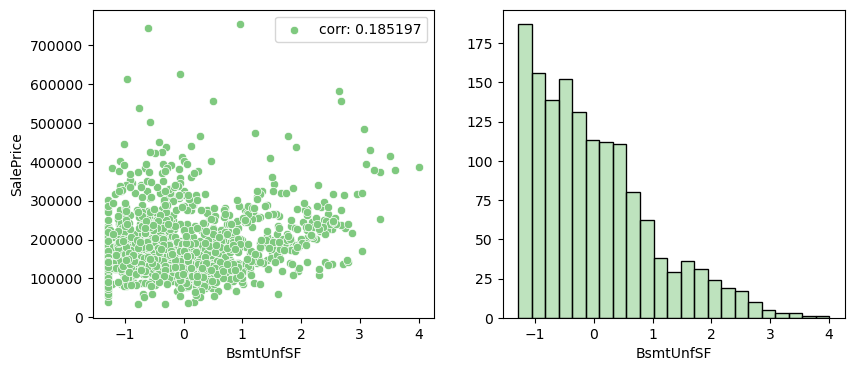

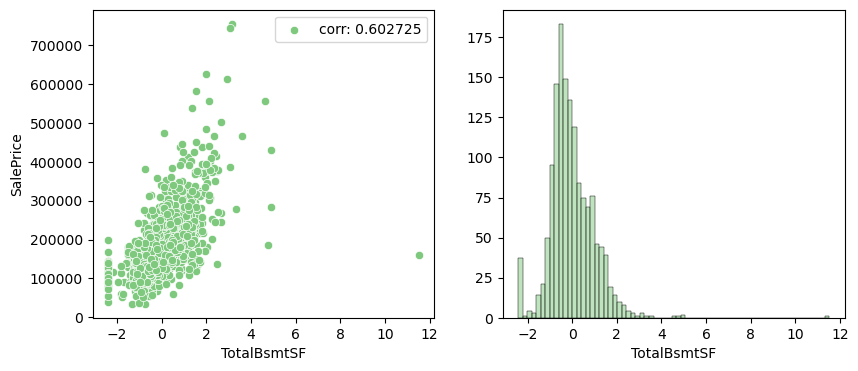

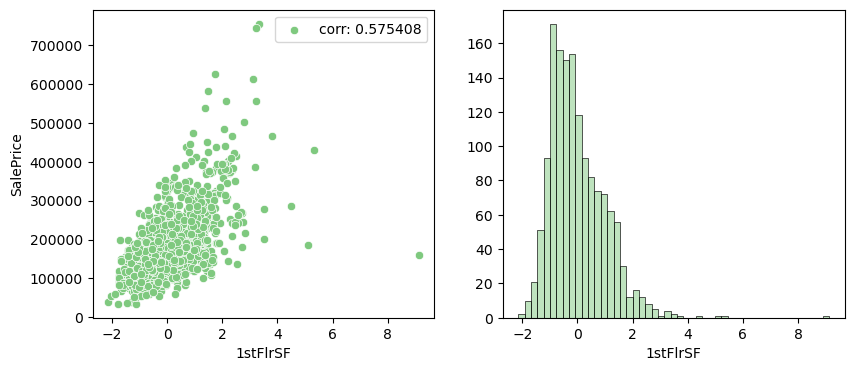

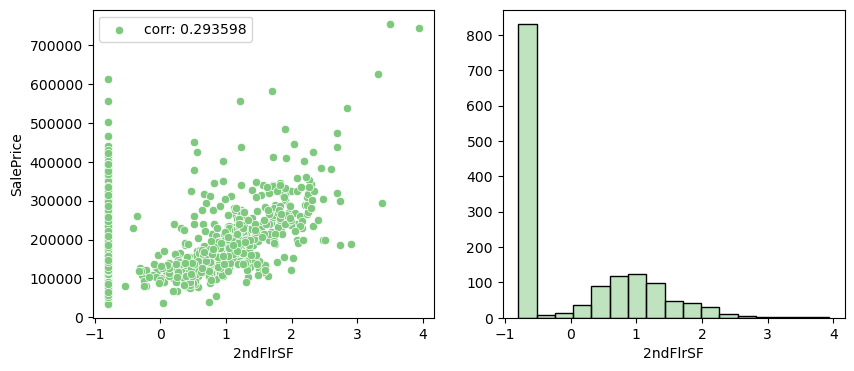

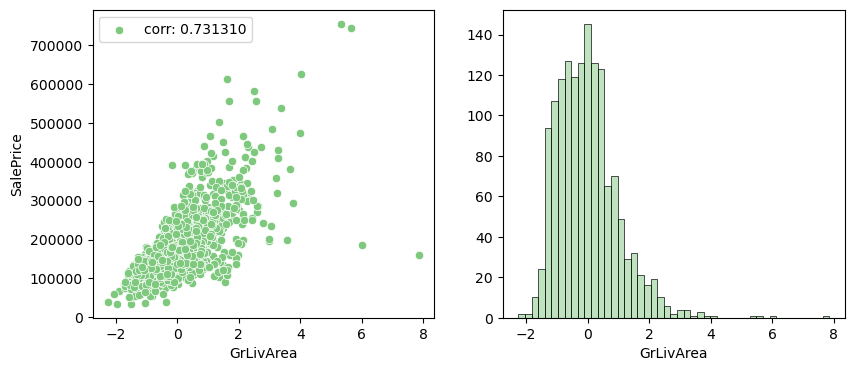

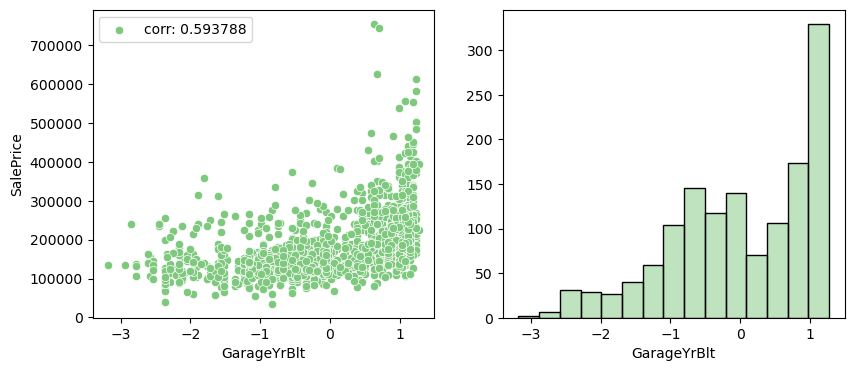

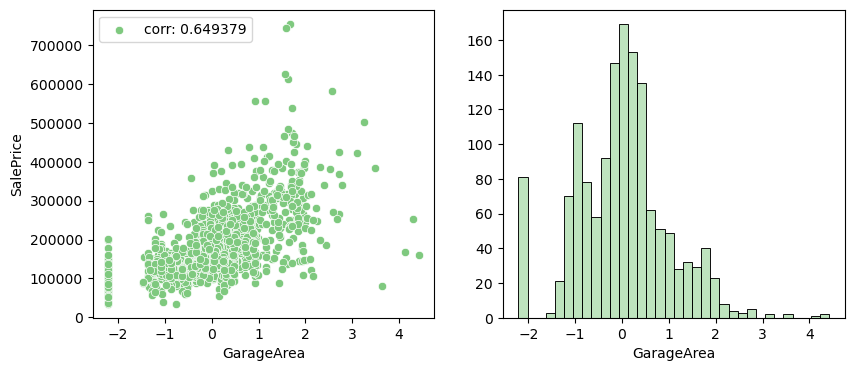

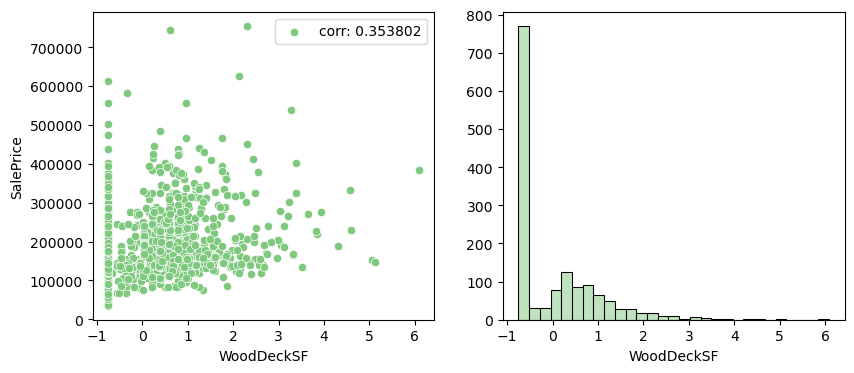

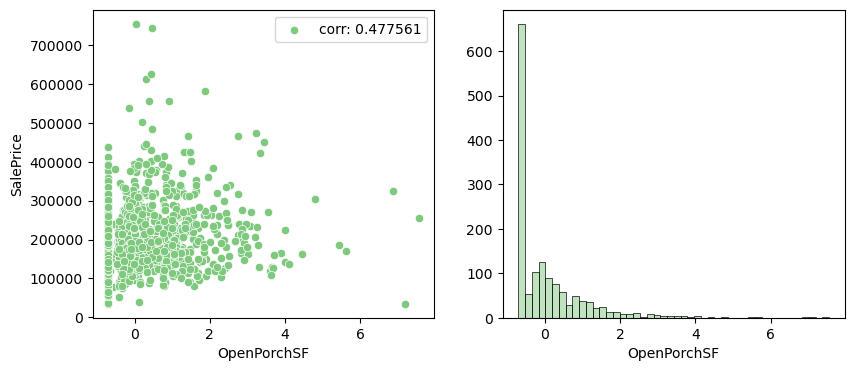

In [179]:
for c in num_cols_norm:
    plot_num_col(c, df=tdf)

In [195]:
from sklearn.preprocessing import PowerTransformer

In [192]:
tdf[num_cols_norm] = df[num_cols_norm] 

In [197]:
power = PowerTransformer(method='yeo-johnson', standardize=True)
tdf[num_cols_norm] = power.fit_transform(tdf[num_cols_norm])

In [198]:
tdf[num_cols_norm]

LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
0       -0.118925 -0.141171   1.151867      0.908055    1.224910    0.797537   
1        0.508345  0.105609   0.006695     -0.621670   -0.822092    1.011471   
2        0.013008  0.413721   1.055357      0.835594    1.187565    0.571325   
3       -0.347206  0.095490  -1.629540     -0.863478   -0.822092    0.142272   
4        0.663404  0.877127   1.007861      0.694898    1.328843    0.750541   
...           ...       ...        ...           ...         ...         ...   
1455    -0.254571 -0.266808   0.960863      0.694898   -0.822092   -1.353159   
1456     0.701469  0.722071   0.080711     -0.041619    1.123494    0.869532   
1457    -0.074548 -0.010330  -1.061347      1.134227   -0.822092    0.261742   
1458     0.013008  0.129088  -0.823991      0.429676   -0.822092   -0.460226   
1459     0.307799  0.172505  -0.373250     -1.043880   -0.822092    0.901757   

      BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  GarageYrBlt  \
0     -0.887576    -0.404029 -0.799624  1.170239   0.528531     1.079067   
1     -0.434388     0.508177  0.429151 -0.871454  -0.382755    -0.282100   
2     -0.048083    -0.253787 -0.568533  1.172896   0.659112     0.959447   
3      0.183337    -0.644806 -0.429428  1.146834   0.540797     0.786228   
4      0.077485     0.254387  0.124698  1.209630   1.282894     0.900890   
...         ...          ...       ...       ...        ...          ...   
1455   0.909505    -0.177387 -0.456061  1.130187   0.415837     0.843154   
1456   0.282161     1.092127  1.946238 -0.871454   1.106859    -0.198196   
1457   0.790731     0.269755  0.240338  1.226211   1.471180    -1.419734   
1458  -2.064084     0.106028 -0.065163 -0.871454  -0.854788    -1.179620   
1459  -0.945776     0.495315  0.414293 -0.871454  -0.397037    -0.703021   

      GarageArea  WoodDeckSF  OpenPorchSF  
0       0.383899   -0.950337     0.841820  
1      -0.004602    1.213714    -1.071307  
2       0.641990   -0.950337     0.668453  
3       0.786092   -0.950337     0.584540  
4       1.583257    1.079695     0.991895  
...          ...         ...          ...  
1455   -0.004602   -0.950337     0.645943  
1456    0.173581    1.260813    -1.071307  
1457   -0.987927   -0.950337     0.834100  
1458   -1.048544    1.274883    -1.071307  
1459   -0.868284    1.475782     0.892639  

[1460 rows x 15 columns]

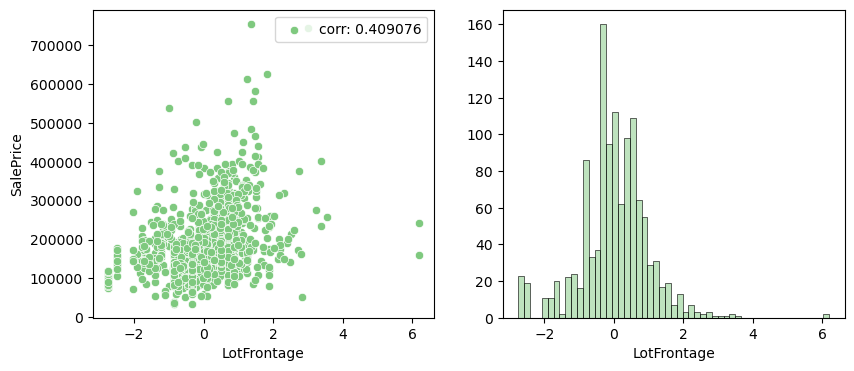

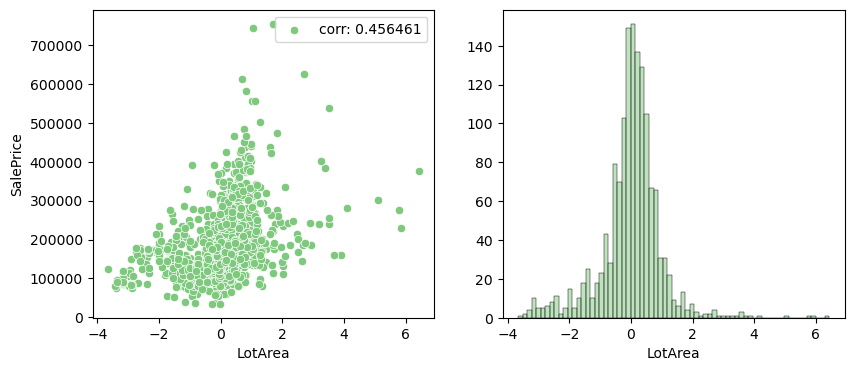

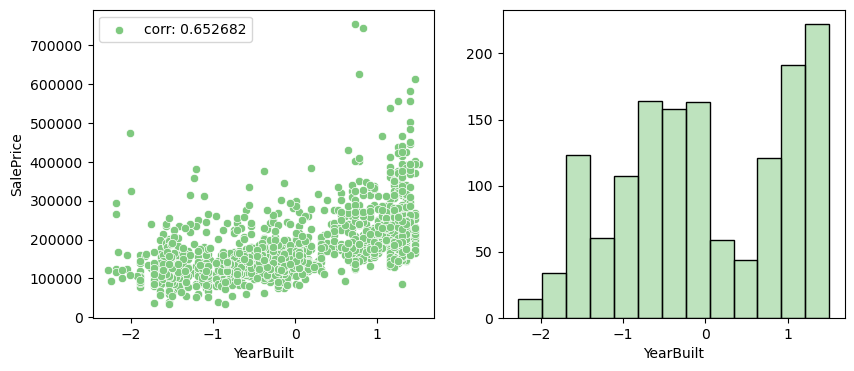

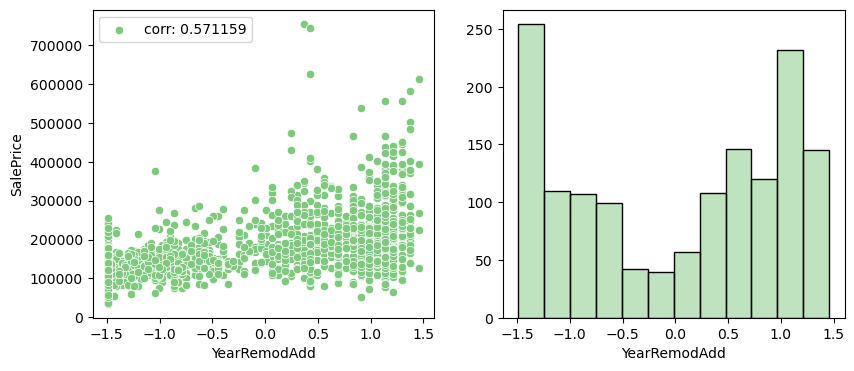

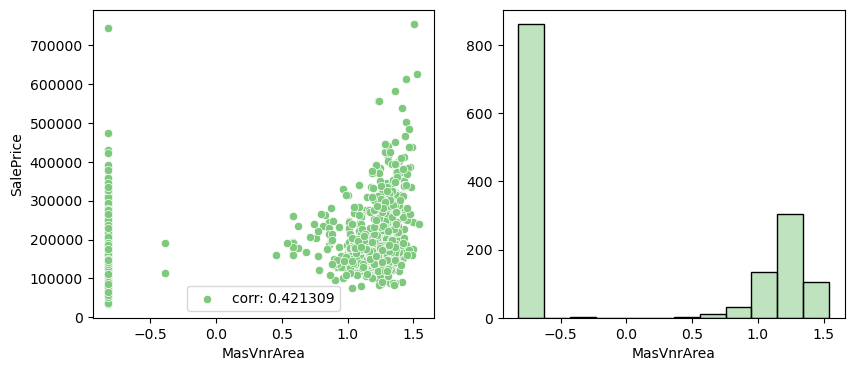

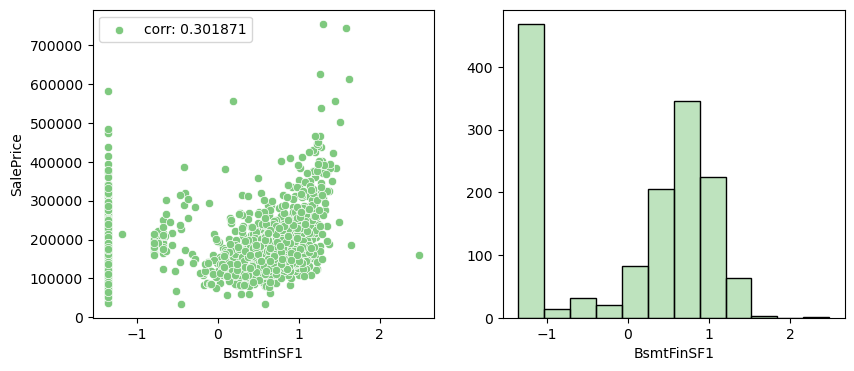

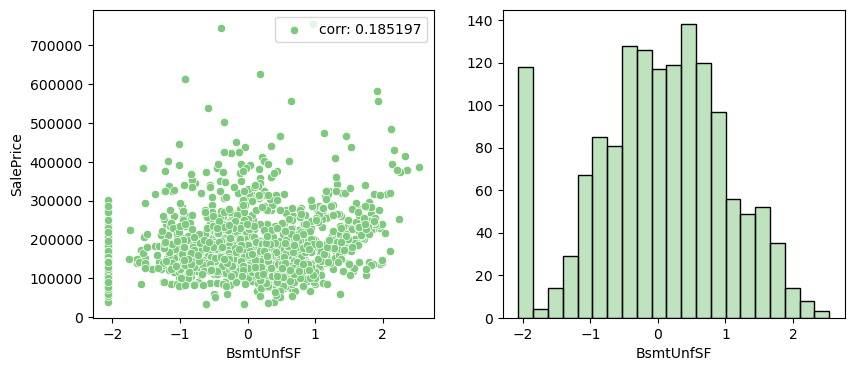

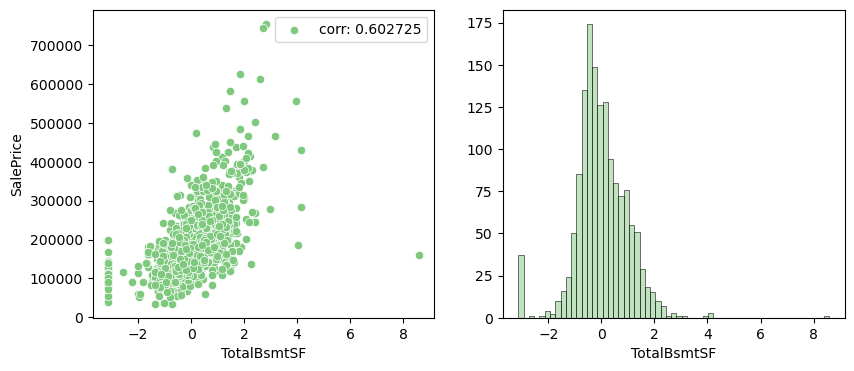

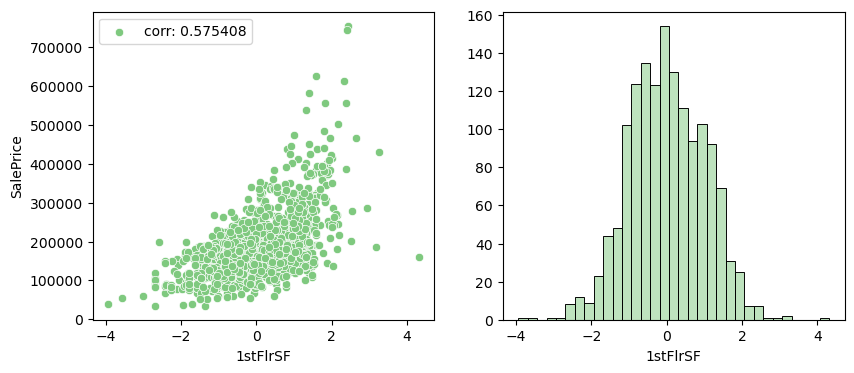

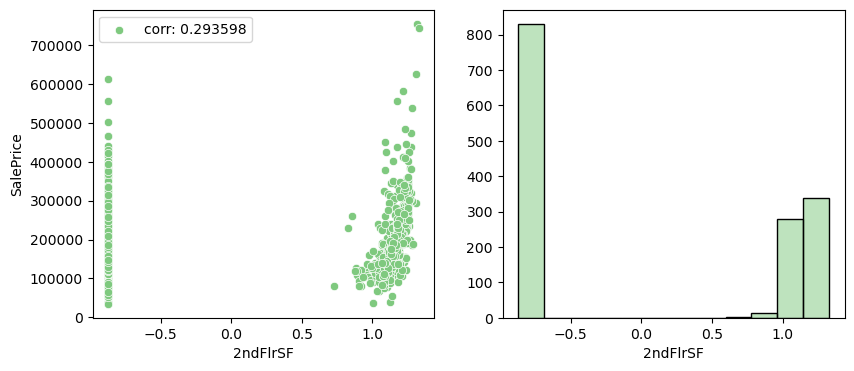

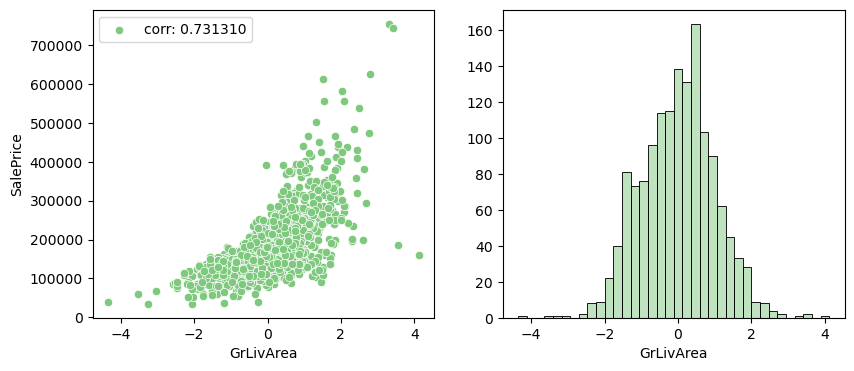

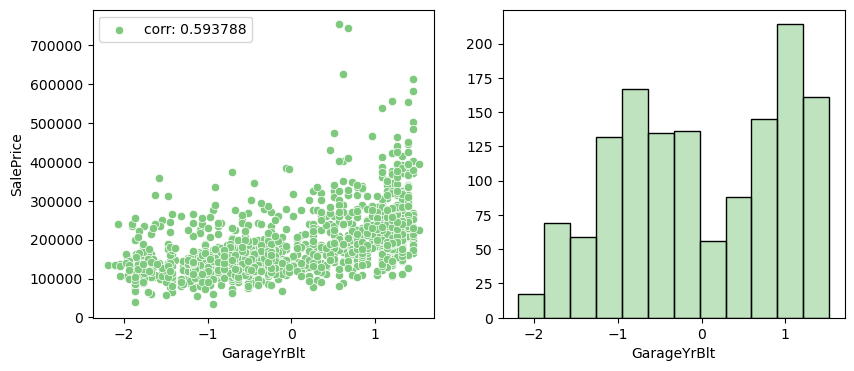

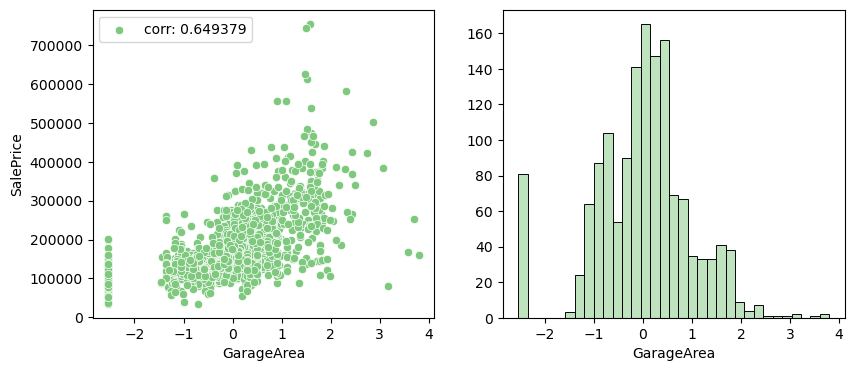

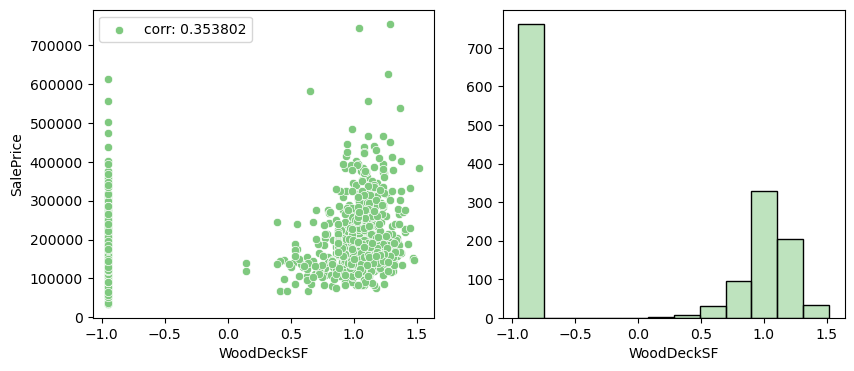

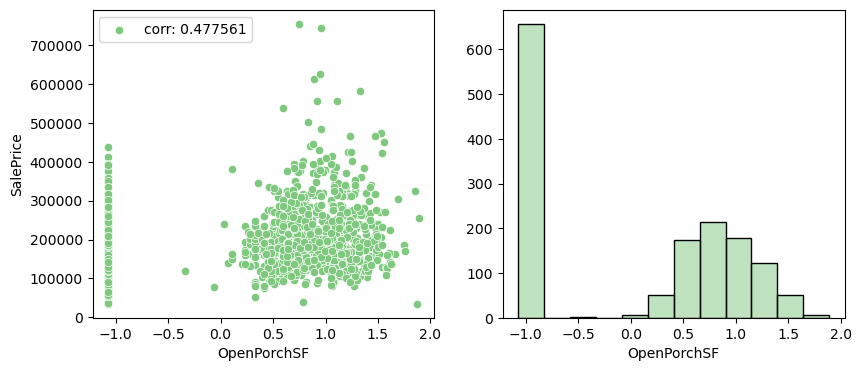

In [199]:
for c in num_cols_norm:
    plot_num_col(c, df=tdf)

In [189]:
tdf[num_cols_norm] = power_transform(tdf[num_cols_norm] , method='box-cox')

ValueError: The Box-Cox transformation can only be applied to strictly positive data

In [ ]:
for c in num_cols_norm:
    plot_num_col(c, df=tdf)